In [150]:
import snowflake.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from snowflake.sqlalchemy import URL
from sqlalchemy import create_engine
import pyarrow
import json
import math
from ast import literal_eval
from pandas.io.json import json_normalize
import great_expectations as ge
from datetime import datetime as dt
from operator import itemgetter
from sklearn.preprocessing import LabelEncoder
import os

In [6]:
portalConn = snowflake.connector.connect(
    user = 'awolfson',
    password = '',
    account = 'dja82100',
    region = 'us-east-1',
    warehouse = 'EXPLORER_WH',
    database = 'CDP_RAW',
    schema = 'PORTAL_PROD',
    authenticator = 'externalbrowser'
)

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...


In [7]:
portalBackendConn = snowflake.connector.connect(
    user = 'awolfson',
    password = '',
    account = 'dja82100',
    region = 'us-east-1',
    warehouse = 'EXPLORER_WH',
    database = 'CDP_RAW',
    schema = 'PORTAL_BACKEND_PROD',
    authenticator = 'externalbrowser'
)

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...


In [8]:
rawConn = snowflake.connector.connect(
    user = 'awolfson',
    password = '',
    account = 'dja82100',
    region = 'us-east-1',
    warehouse = 'EXPLORER_WH',
    database = 'RAW',
    schema = 'PORTAL_MYSQL_CAIS',
    authenticator = 'externalbrowser'
)

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...


In [9]:
analyticsConn = snowflake.connector.connect(
    user = 'awolfson',
    password = '',
    account = 'dja82100',
    region = 'us-east-1',
    warehouse = 'EXPLORER_WH',
    database = 'ANALYTICS',
    schema = 'DBT_PRODUCTION',
    authenticator = 'externalbrowser'
)

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...


In [10]:
hubspotConn = snowflake.connector.connect(
    user = 'awolfson',
    password = '',
    account = 'dja82100',
    region = 'us-east-1',
    warehouse = 'EXPLORER_WH',
    database = 'ANALYTICS',
    schema = 'DBT_PRODUCTION_HUBSPOT',
    authenticator = 'externalbrowser'
)

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...


In [11]:
caisIQConn = snowflake.connector.connect(
    user = 'awolfson',
    password = '',
    account = 'dja82100',
    region = 'us-east-1',
    warehouse = 'EXPLORER_WH',
    database = 'CDP_RAW',
    schema = 'CAIS_IQ_PROD',
    authenticator = 'externalbrowser'
)

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...


### Queries

In [12]:
def create_simple_table(conn):

    cur = conn.cursor()
    query = """
    select user_id, timestamp, 'Identify' as event, 'Identify' as event_text from identifies
    union all select user_id, timestamp, event, event_text from tracks order by timestamp asc
    """


    cur.execute(query)
    output = cur.fetch_pandas_all()
    return(output)

In [13]:
#simpleTable =create_simple_table(portalConn)
#simpleTable.sort_values(by = 'TIMESTAMP')
#simpleTable

In [14]:
def create_complex_table(conn):

    cur = conn.cursor()
    query = """
    select user_id, timestamp as time, event_text as event, object_construct(*) as json from Document_downloaded
    union all select user_id, timestamp as time, event_text as event, object_construct_keep_null(*) as json from product_viewed
    union all select user_id, timestamp as time, event_text as event, object_construct_keep_null(*) as json from product_video_clicked
    union all select user_id, timestamp as time, event_text as event, object_construct_keep_null(*) as json from subscribe_clicked
    union all select user_id, timestamp as time, 'Page View' as event, object_construct_keep_null(*) as json from pages
    union all select user_id, timestamp as time, event_text as event, object_construct_keep_null(*) as json from "CDP_RAW"."PORTAL_BACKEND_PROD"."SIGNED_IN"
    union all select user_id, timestamp as time, 'Document Downloaded: Backend' as event, object_construct_keep_null(*) as json from "CDP_RAW"."PORTAL_BACKEND_PROD"."DOCUMENT_DOWNLOADED"
    union all select user_id, timestamp as time, event_text as event, object_construct_keep_null(*) as json from "CDP_RAW"."PORTAL_BACKEND_PROD"."STRUCTURED_PRODUCT_VIEWED"
    union all select user_id, timestamp as time, event_text as event, object_construct_keep_null(*) as json from "CDP_RAW"."PORTAL_BACKEND_PROD"."ACCOUNT_CREATED"
    union all select user_id, timestamp as time, event_text as event, object_construct_keep_null(*) as json from "CDP_RAW"."PORTAL_BACKEND_PROD"."PASSWORD_RESET_REQUESTED"
    union all select user_id, timestamp as time, event_text as event, object_construct_keep_null(*) as json from "CDP_RAW"."PORTAL_BACKEND_PROD"."ACCOUNT_LOCKED"
    """


    cur.execute(query)
    output = cur.fetch_pandas_all()
    return(output)


In [15]:
def segment_table_fund(conn):
    cur = conn.cursor()
    query = """
    select user_id, timestamp as time, event_text as event, product_id as fund_id, object_construct(*) as json from Document_downloaded
    union all select user_id, timestamp as time, event_text as event, fund_id, object_construct_keep_null(*) as json from product_viewed
    union all select user_id, timestamp as time, event_text as event, fund_id, object_construct_keep_null(*) as json from product_video_clicked
    union all select user_id, timestamp as time, event_text as event, fund_id, object_construct_keep_null(*) as json from subscribe_clicked
    union all select user_id, timestamp as time, 'Page View' as event, fund.fund_id as fund_id, object_construct_keep_null(*) as json from pages
    left outer join "ANALYTICS"."DBT_PRODUCTION"."DIM_FUND" fund on pages.url like concat('%/', fund.fund_id, '%')
    where (pages.url like concat('%/', fund.fund_id) or pages.url like concat('%/', fund.fund_id, '/%'))
    and pages.url not like concat('%fund-managers/', fund.fund_id,'%')
    and fund_id is not null
    union all select user_id, timestamp as time, 'Document Downloaded: Backend' as event, fund.fund_id as fund_id ,object_construct_keep_null(*) as json from "CDP_RAW"."PORTAL_BACKEND_PROD"."DOCUMENT_DOWNLOADED" d
    left join "ANALYTICS"."DBT_PRODUCTION"."DIM_FUND" fund on d.file_name like concat('%',fund.fund_name,'%')
    where fund.fund_id is not null and fund.fund_name <>'' and fund.fund_id != -99
    """


    cur.execute(query)
    output = cur.fetch_pandas_all()
    return(output)


In [16]:
def get_user_emails(conn):
    cur = conn.cursor()
    query = """
    select user_id, email, full_name from stg_portal__users
    where email is not null and email not like '%caisgroup.com%' and email not like '%test%' 
    and email not like '%demo%' and full_name not like '%test%'
    and full_name not like '%demo%'
    """
    
    cur.execute(query)
    output = cur.fetch_pandas_all()
    return(output)

In [17]:
def get_webinar_data(conn):

    cur = conn.cursor()
    query = """
    select a.email as email, 'Attended Webinar' as event ,users.user_id, users.full_name, 
    e.livestart as time, object_construct_keep_null(a.*) as json, object_construct_keep_null(e.*) as json2,
    object_construct_keep_null(t.*) as json3
    from stg_on24__attendees  a
    left join stg_on24__events e on a.eventid = e.eventid
    left join stg_on24__tags t on a.eventid = t.event_id
    left join stg_portal__users users on a.email = users.email
    where livestart >='2021-04-16' and user_id is not null
    and users.email is not null and users.email not like '%caisgroup.com%' and users.email not like '%test%' 
    and users.email not like '%auth0%' and users.email not like '%demo%'
    """

    cur.execute(query)
    output = cur.fetch_pandas_all()
    return(output)

In [18]:
def get_webinar_fund_data(conn):
    cur = conn.cursor()
    query = """
    select a.email as email, 'Attended Webinar' as event ,users.user_id, users.full_name, 
    e.livestart as time, object_construct_keep_null(a.*) as json, object_construct_keep_null(e.*) as json2,
    object_construct_keep_null(t.*) as json3
    from stg_on24__attendees  a
    left join stg_on24__events e on a.eventid = e.eventid
    left join stg_on24__tags t on a.eventid = t.event_id
    left join stg_portal__users users on a.email = users.email
    where livestart >='2021-04-16' and user_id is not null
    and users.email is not null and users.email not like '%caisgroup.com%' and users.email not like '%test%' 
    and users.email not like '%auth0%' and users.email not like '%demo%' and t.fund_id is not null
    """

    cur.execute(query)
    output = cur.fetch_pandas_all()
    return(output)

In [19]:
def get_email_events(conn):
    cur = conn.cursor()
    query = """
    select created_timestamp as time, 'Email Bounce' as event, object_construct_keep_null(*) as json,
    recipient_email_address as email from hubspot__email_event_bounce where time >'2021-04-08'
    union all select created_timestamp as time, 'Email Click' as event, object_construct_keep_null(*) as json,
    recipient_email_address as email from hubspot__email_event_clicks where time >'2021-04-08'
    union all select created_timestamp as time, 'Email Dropped' as event, object_construct_keep_null(*) as json,
    recipient_email_address as email from hubspot__email_event_dropped where time >'2021-04-08'
    union all select created_timestamp as time, 'Email Forwarded' as event, object_construct_keep_null(*) as json,
    recipient_email_address as email from hubspot__email_event_forward where time >'2021-04-08'
    union all select created_timestamp as time, 'Email Opened' as event, object_construct_keep_null(*) as json,
    recipient_email_address as email from hubspot__email_event_opens where time >'2021-04-08'
    union all select created_timestamp as time, 'Email Sent' as event, object_construct_keep_null(*) as json,
    recipient_email_address as email from hubspot__email_event_sent where time >'2021-04-08'
    """
    
    cur.execute(query)
    output = cur.fetch_pandas_all()
    return(output)

In [20]:
def get_email_fund_events(conn):
    cur = conn.cursor()
    query = """
    select emails.*, object_construct_keep_null(campaign.*) as campaignJSON, fund.fund_id, fund.fund_name from 
    (select created_timestamp as time, 'Email Bounce' as event,email_campaign_id,  object_construct_keep_null(*) as json,
    recipient_email_address as email from hubspot__email_event_bounce where time >'2021-04-08'
    union all select created_timestamp as time, 'Email Click' as event,email_campaign_id, object_construct_keep_null(*) as json,
    recipient_email_address as email from hubspot__email_event_clicks where time >'2021-04-08'
    union all select created_timestamp as time, 'Email Dropped' as event,email_campaign_id, object_construct_keep_null(*) as json,
    recipient_email_address as email from hubspot__email_event_dropped where time >'2021-04-08'
    union all select created_timestamp as time, 'Email Forwarded' as event, email_campaign_id,object_construct_keep_null(*) as json,
    recipient_email_address as email from hubspot__email_event_forward where time >'2021-04-08'
    union all select created_timestamp as time, 'Email Opened' as event, email_campaign_id,object_construct_keep_null(*) as json,
    recipient_email_address as email from hubspot__email_event_opens where time >'2021-04-08'
    union all select created_timestamp as time, 'Email Sent' as event, email_campaign_id,object_construct_keep_null(*) as json,
    recipient_email_address as email from hubspot__email_event_sent where time >'2021-04-08') as emails
    left join hubspot__email_campaigns campaign on campaign.email_campaign_id= emails.email_campaign_id
    left outer join "ANALYTICS"."DBT_PRODUCTION"."DIM_FUND" fund on campaign.email_campaign_subject like concat('%',fund.fund_name,'%')
    where fund.fund_name is not null and fund.fund_id != -99
    """
    
    cur.execute(query)
    output = cur.fetch_pandas_all()
    return(output)

In [21]:
def get_user_and_firm_info(conn):

    cur = conn.cursor()
    query = """
    select a.id, b.email, b.full_name, b.firm_id, c.firm_full_name from users as a 
    join "ANALYTICS"."DBT_PRODUCTION"."STG_PORTAL__USERS" as b on a.id = b.user_id
    join "ANALYTICS"."DBT_PRODUCTION"."STG_PORTAL__FIRM_ANALYTICS" as c on b.firm_id = c.firm_id
    where b.email is not null and b.email not like '%caisgroup.com%' and b.email not like '%test%'
    and b.email not like '%demo%'
    """


    cur.execute(query)
    output = cur.fetch_pandas_all()
    return(output)

In [22]:
def get_holding_page_view_info(conn):
    cur = conn.cursor()
    query = """
    
    select referrer, title, user_ID, url from pages where title like '%Holding%' 
    """
    
    cur.execute(query)
    output = cur.fetch_pandas_all()
    return(output)

In [23]:
def see_most_viewed_pages_full(conn):

    cur = conn.cursor()
    query = """
    select user_id, title from pages 
    """


    cur.execute(query)
    output = cur.fetch_pandas_all()
    return(output)

In [24]:
def get_subscribe_clicked(conn):
    cur = conn.cursor()
    query = """
    
    select a.user_id as user_id, a.status, a.strategy, a.short_name, a.received_at as time, a.fund_id as fund_id, 
    a.event_text as event_text, b.firm_id, b.full_name 
    from subscribe_clicked as a
    left join "ANALYTICS"."DBT_PRODUCTION"."STG_PORTAL__USERS" as b on a.user_id = b.user_id
    where b.email is not null and b.email not like '%caisgroup.com%' and b.email not like '%test%' 
    and b.email not like '%auth0%'
    """
    
    cur.execute(query)
    output = cur.fetch_pandas_all()
    return(output)

In [25]:
def get_transactions(conn):
    cur = conn.cursor()
    query = """
    
    select a.createdate as time, a.investmentdate, 
    'transaction' as event_text, a.productid as fund_id, a.updatedate,  
    a.userid as user_id,  b.firm_id, b.full_name 
    from transaction as a
    left join "ANALYTICS"."DBT_PRODUCTION"."STG_PORTAL__USERS" as b on a.userid = b.user_id
    where b.email is not null and b.email not like '%caisgroup.com%' and b.email not like '%test%' 
    and b.email not like '%auth0%'
    and _fivetran_deleted = FALSE and deletedate is null and a.userid is not null and createdate>='2021-04-16' 
    and _fivetran_active is not null
    order by createdate asc
    """
    
    cur.execute(query)
    output = cur.fetch_pandas_all()
    return(output)

In [26]:
def holdings_referrers(conn):
    cur = conn.cursor()
    query = """
    
    select referrer, title, user_ID, url from pages 
    where referrer like '%holding%' or referrer like '%cais-accounts%'
    """
    
    cur.execute(query)
    output = cur.fetch_pandas_all()
    return(output)

In [27]:
def get_cais_iq_data(conn):
    
    cur = conn.cursor()
    sql = """
    select user_id, timestamp as time, event_text as event, object_construct(*) as json from ARTICLE_CLICKED
    union all select user_id, timestamp as time, event_text as event, object_construct_keep_null(*) as json from course_card_clicked
    union all select user_id, timestamp as time, event_text as event, object_construct_keep_null(*) as json from external_link_clicked
    union all select user_id, timestamp as time, event_text as event, object_construct_keep_null(*) as json from fund_course_clicked
    union all select user_id, timestamp as time, event_text as event, object_construct_keep_null(*) as json from logout_clicked
    union all select user_id, timestamp as time, event_text as event, object_construct_keep_null(*) as json from presenter_clicked
    union all select user_id, timestamp as time, event_text as event, object_construct_keep_null(*) as json from presenter_modal_video_clicked
    union all select user_id, timestamp as time, event_text as event, object_construct_keep_null(*) as json from schedule_download_clicked
    union all select user_id, timestamp as time, event_text as event, object_construct_keep_null(*) as json from sign_up_free_clicked
    union all select user_id, timestamp as time, event_text as event, object_construct_keep_null(*) as json from video_playback_cancelled
    union all select user_id, timestamp as time, event_text as event, object_construct_keep_null(*) as json from video_playback_completed
    union all select user_id, timestamp as time, event_text as event, object_construct_keep_null(*) as json from video_playback_started
    union all select user_id, timestamp as time, event_text as event, object_construct_keep_null(*) as json from view_learning_center_button_clicked
    union all select user_id, timestamp as time, event_text as event, object_construct_keep_null(*) as json from view_reporting_button_clicked
    union all select user_id, timestamp as time, event_text as event, object_construct_keep_null(*) as json from whitepaper_clicked
    union all select user_id, timestamp as time, event_text as event, object_construct_keep_null(*) as json from whitepaper_download_clicked
    """


    cur.execute(sql)
    df = cur.fetch_pandas_all()
    df["JSON"] = df["JSON"].apply(json.loads)
    return(df)

In [28]:
def sf_opportunity_extraction(conn):
    cur = conn.cursor()
    sql = """
    select opp.created_date as time, 'Transaction Intent' as event, 
    object_construct_keep_null(opp.*) as json, c.email, fund.portal_fund_id_c as fund_id, fund.portal_fund_name_c as fund_name
    from stg_salesforce__opportunities opp 
    left join stg_salesforce__contacts c on opp.contact_c = c.contact_id
    left outer join stg_salesforce__fund_c fund on opp.fund_c = fund.id
    where opp.opportunity_id in
    (select distinct opportunity_id from stg_salesforce__opportunity_field_hist where field = 'StageName' and
    (old_value like '%Indication%' or new_value like '%Indication%') and created_date >='2021-04-16')
    and c.email is not null and time >='2021-04-16' and fund.portal_fund_id_c is not null
    union all
    select date_c as time, type_of_activity_c as event, object_construct_keep_null(activity.*) as json, contact.email, fund.portal_fund_id_c as fund_id, fund.portal_fund_name_c as fund_name
    from stg_salesforce__sales_activity_c as activity
    join stg_salesforce__contacts contact on activity.contact_c = contact.contact_id
    left outer join stg_salesforce__fund_c fund on activity.funds_discussed_c like concat('%',fund.name,'%')
    where time >'2021-04-16' and fund.portal_fund_id_c is not null
    """
    
    cur.execute(sql)
    df = cur.fetch_pandas_all()
    return(df)

In [29]:
def sf_interaction_data(conn):
    cur = conn.cursor()
    sql = """
    select t.completed_date_time as time, 
    t.task_subtype as event, object_construct_keep_null(t.*) as json, c.full_name, c.email
    from stg_salesforce__task as t
    join stg_salesforce__contacts c on t.who_id = c.contact_id
    where t.add_sales_activity_c is null and time >'2021-04-16' and t.task_subtype = 'Email'
    """
    
    cur.execute(sql)
    df = cur.fetch_pandas_all()
    return(df)

In [30]:
def get_team_and_firm_info(conn):
    cur = conn.cursor()
    sql = """
    select u.user_id, u.advisor_team_id, t.firm_id, t.team_name,c.full_name as FIRM_NAME, c.client_type
    from stg_portal__user_advisorteams u 
    join stg_portal__advisor_teams t on t.advisor_team_id = u.advisor_team_id
    join stg_portal__clients c on c.client_id = t.firm_id
    """

    cur.execute(sql)
    df = cur.fetch_pandas_all()
    return(df)

### Functions

In [31]:
def user_slice(df, userID):
    return(df.loc[df['USER_ID'].isin([userID])])

In [32]:
def team_slice(df, teamID):
    return(df.loc[df['ADVISOR_TEAM_ID'].isin([teamID])])

In [33]:
def firm_slice(df, firmID):
    return(df.loc[df['FIRM_ID'].isin([firmID])])

In [34]:
def user_slice_index(df, userID):
    return(df.loc[df.index.isin([userID])])

In [35]:
def team_slice_index(df, teamID):
    return(df.loc[df.index.isin([teamID])])

In [36]:
def firm_slice_index(df, firmID):
    return(df.loc[df.index.isin([firmID])])

In [37]:
#Deprecated: use the other create user journey method on a tupleJourney DF
def simpleUserInteraction(df):
    df['Num Logins'] = ''
    df['Num Clicks'] = ''
    for index, row in df.iterrows():
        eventlist = df.at[index, 'EVENT']
        logins = 0
        events = 0
        for i in range(len(eventlist)):
            event = eventlist[i]
            if (event == 'Signed In') | (event == 'Identify'):
                logins += 1
            else:
                events += 1
        df.at[index, 'Num Logins'] = logins
        df.at[index, 'Num Clicks'] = int(events)
    return(df)

In [38]:
def merge_webinar_jsons(row):
    json1 = json.loads(row['JSON'])
    json2 = json.loads(row['JSON2'])
    json3 = json.loads(row['JSON3'])
    json1['DESCRIPTION'] = json2.get('DESCRIPTION')
    json1['FUND_IDS'] = json3.get('FUND_ID')
    json1['EVENT_NAME'] = json3.get('EVENT_NAME')
    json1['FUND_MANAGER']= json3.get('FUND_MANAGER')
    return(json1)

In [39]:
def merge_salesforce_fund(row):
    json1 = json.loads(row['JSON'])
    json1['FUND_ID'] = row['FUND_ID']
    json1['FUND_NAME'] = row['FUND_NAME']
    return(json1)

In [40]:
def get_user_id_from_email(someDF, emailDF):
    return(pd.merge(someDF, emailDF, how= 'left', left_on = 'EMAIL', right_on = 'EMAIL'))

In [41]:
#connect with create complex table function/query
#output from there goes in here to make tuple journey
def create_simple_tuple_journey_user(df):
    final = pd.DataFrame()
    userIDs = pd.unique(df['USER_ID'])
    final['USER_ID'] = userIDs
    final['Journey'] = [[]] * final.shape[0]
    index = 0
    print(len(userIDs))
    df_search = df.set_index('USER_ID')
    for i in userIDs:
        print(index)
        view = user_slice_index(df_search, i)
        final.at[index,'Journey'] = list(zip(view['TIME'],view['EVENT'],view['JSON']))
        index += 1
    return(final)

In [42]:
def tuple_journey(df):
    df = df.sort_values(by = 'TIME')
    return(list(zip(df['TIME'],df['EVENT'],df['JSON'])))

In [43]:
def create_simple_tuple_journey_advisor_team(df):
    final = pd.DataFrame()
    teamIDs = pd.unique(df['ADVISOR_TEAM_ID'])
    final['ADVISOR_TEAM_ID'] = teamIDs
    final['Journey'] = [[]] * final.shape[0]
    index = 0
    print(len(teamIDs))
    df_search = df.set_index('ADVISOR_TEAM_ID')
    for i in teamIDs:
        print(index)
        view = team_slice_index(df_search, i)
        final.at[index,'Journey'] = list(zip(view['TIME'],view['EVENT'],view['JSON']))
        index += 1
    return(final)

In [44]:
def create_simple_tuple_journey_firm(df):
    final = pd.DataFrame()
    firmIDs = pd.unique(df['FIRM_ID'])
    final['FIRM_ID'] = firmIDs
    final['Journey'] = [[]] * final.shape[0]
    index = 0
    print(len(firmIDs))
    df_search = df.set_index('FIRM_ID')
    for i in firmIDs:
        print(index)
        view = firm_slice_index(df_search, i)
        final.at[index,'Journey'] = list(zip(view['TIME'],view['EVENT'],view['JSON']))
        index += 1
    return(final)

In [45]:
#add handling for no logins
def session_view_login(tupleJourney):
    output = pd.DataFrame()
    sessionData = pd.DataFrame()
    sessionData['User ID'] = ''
    sessionData['Session Number'] = 0
    sessionData['Session Start Time'] = 0
    sessionData['Session End Time'] = 0
    sessionData['Session Duration'] = 0
    sessionData['Session Clicks'] = 0
    sessionData['More Info'] = ''
    for index, row in tupleJourney.iterrows():
        print(index)
        sessionNumber = 0
        sessionClicks = 0
        extraInfo = []
        sessionData.at[0,'User ID'] = row[0]
        lastInteractionTime = 0
        for interaction in row.loc['Journey']:
            if interaction[1] == "login":
                if sessionNumber ==0:
                    #initiate first session
                    pass
                else:
                    sessionData.at[0,'Session End Time'] = lastInteractionTime
                    sessionData.at[0,'Session Duration'] = sessionData.at[0,'Session End Time'] - sessionData.at[0,'Session Start Time']
                    sessionData.at[0,'Session Clicks'] = int(sessionClicks)
                    sessionData.at[0,'More Info'] = extraInfo
                    extraInfo.clear()
                    output = pd.concat([output, sessionData],ignore_index = True)
                #Reset all session info to start gathering data for next session
                lastInteractionTime = interaction[0].replace(microsecond=0)
                extraInfo.append(interaction[2])
                sessionClicks = 0
                sessionNumber +=1
                sessionData.at[0,'Session Number'] = sessionNumber
                sessionData.at[0,'Session Start Time'] = interaction[0].replace(microsecond=0)
            else:
                if sessionNumber ==0:
                    continue #the first interaction isn't a login WARNING
                extraInfo.append(interaction[2])
                sessionClicks +=1
                lastInteractionTime = interaction[0].replace(microsecond=0)
        
        sessionData.at[0,'Session End Time'] = lastInteractionTime
        if lastInteractionTime ==0:
            sessionData.at[0,'Session Duration'] = 0
        else:
            sessionData.at[0,'Session Duration'] = sessionData.at[0,'Session End Time'] - sessionData.at[0,'Session Start Time']
        sessionData.at[0,'Session Clicks'] = int(sessionClicks)
        output = pd.concat([output, sessionData],ignore_index = True)
    return(output)

In [46]:
def session_view_daily(tupleJourney):
    output = pd.DataFrame()
    sessionData = pd.DataFrame()
    sessionData['User ID'] = ''
    sessionData['Session Number'] = 0
    sessionData['Session Start Time'] = 0
    sessionData['Session End Time'] = 0
    sessionData['Session Duration'] = 0
    sessionData['Session Clicks'] = 0
    sessionData['Session Logins'] = 0
    sessionData['More Info'] = ''
    for index, row in tupleJourney.iterrows():
        extraInfo = []
        sessionNumber = 1
        sessionClicks = 0
        sessionLogins = 0
        sessionData.at[0,'User ID'] = row.loc['USER_ID']
        lastInteractionTime = 0
        if len(row.loc['Journey'])==0:
            sessionData.at[0,'More Info'] = "No activity for this user yet."
            sessionData.at[0,'Session Duration'] = 0
            sessionData.at[0,'Session Number'] = 0
            sessionData.at[0,'Session End Time'] = 0
            sessionData.at[0,'Session Start Time'] = 0
            sessionData.at[0,'Session Clicks'] = int(sessionClicks)
            sessionData.at[0,'Session Logins'] = sessionLogins
            output = pd.concat([output, sessionData],ignore_index = True)
            continue
        else:
            sessionStart = row[1][0][0].replace(microsecond=0)
            sessionData.at[0,'Session Start Time']= sessionStart
            for interaction in row.loc['Journey']:
                #check if we are still in the same session
                if interaction[0].date() != sessionStart.date():
                    sessionData.at[0,'Session Number'] = sessionNumber
                    sessionNumber +=1
                    sessionData.at[0,'Session End Time'] = lastInteractionTime
                    sessionData.at[0,'Session Duration'] = lastInteractionTime - sessionStart
                    sessionData.at[0,'Session Clicks'] = sessionClicks
                    sessionData.at[0,'Session Logins'] = sessionLogins
                    sessionData.at[0,'More Info'] = extraInfo
                    extraInfo.clear()
                    sessionClicks = 0
                    sessionLogins = 0
                    output = pd.concat([output,sessionData], ignore_index = True)
                    #end the session, start a new one
                    sessionStart = interaction[0].replace(microsecond=0)
                    sessionData.at[0,'Session Start Time'] = sessionStart
                lastInteractionTime = interaction[0].replace(microsecond=0)
                extraInfo.append(interaction[2])
                if interaction[1] == "login":
                    sessionLogins +=1
                else:
                    sessionClicks +=1
        sessionData.at[0,'Session Number'] = sessionNumber
        sessionData.at[0,'Session End Time'] = lastInteractionTime
        sessionData.at[0,'Session Duration'] = sessionData.at[0,'Session End Time'] - sessionData.at[0,'Session Start Time']
        sessionData.at[0,'More Info'] = extraInfo
        sessionData.at[0,'Session Clicks'] = int(sessionClicks)
        sessionData.at[0,'Session Logins'] = sessionLogins
        output = pd.concat([output, sessionData],ignore_index = True)
    return(output)
            

In [47]:
#Readable user journey for any user after running create_tuple_journey df
def readable_user_journey(tupleJourney, userID):
    index = tupleJourney[tupleJourney['USER_ID'] == userID]['Journey'].index[0]
    userInfo = tupleJourney.loc[tupleJourney['USER_ID'] == userID]['Journey'][index]
    numInteractionsTot = len(userInfo)
    logins = 0
    clicks = 0
    journey = "User Journey \n"
    for i in userInfo:
        if i[1] == 'Signed In':
            logins+=1
            journey = journey + "Login at {}".format(i[0]) + '\n'
        elif i[1] == 'Identify':
            pass
        else:
            clicks +=1
            journey = journey + "{} at {}".format(i[1],i[0]) + '\n'
    headline = "User {} Interaction Summary: {} login(s) and {} event(s).\n".format(userID, logins, clicks)
    output = headline+journey
    print(output)

In [48]:
#Readable user journey for any user after running create_tuple_journey df
def readable_team_journey(tupleJourney, teamID):
    index = tupleJourney[tupleJourney['ADVISOR_TEAM_ID'] == teamID]['Journey'].index[0]
    teamInfo = tupleJourney.loc[tupleJourney['ADVISOR_TEAM_ID'] == teamID]['Journey'][index]
    numInteractionsTot = len(teamInfo)
    logins = 0
    clicks = 0
    journey = "User Journey \n"
    for i in teamInfo:
        if i[1] == 'Signed In':
            logins+=1
            journey = journey + "Login at {}".format(i[0]) + '\n'
        elif i[1] == 'Identify':
            pass
        else:
            clicks +=1
            journey = journey + "{} at {}".format(i[1],i[0]) + '\n'
    headline = "User {} Interaction Summary: {} login(s) and {} event(s).\n".format(teamID, logins, clicks)
    output = headline+journey
    print(output)

In [49]:
#Readable user journey for any user after running create_tuple_journey df
def readable_firm_journey(tupleJourney, firmID):
    index = tupleJourney[tupleJourney['FIRM_ID'] == firmID]['Journey'].index[0]
    firmInfo = tupleJourney.loc[tupleJourney['FIRM_ID'] == firmID]['Journey'][index]
    numInteractionsTot = len(firmInfo)
    logins = 0
    clicks = 0
    journey = "User Journey \n"
    for i in firmInfo:
        if i[1] == 'Signed In':
            logins+=1
            journey = journey + "Login at {}".format(i[0]) + '\n'
        elif i[1] == 'Identify':
            pass
        else:
            clicks +=1
            journey = journey + "{} at {}".format(i[1],i[0]) + '\n'
    headline = "User {} Interaction Summary: {} login(s) and {} event(s).\n".format(firmID, logins, clicks)
    output = headline+journey
    print(output)

In [50]:
def get_url_info(url):
    page = "Unknown"
    lastThree = None
    if isinstance(url,float):
        return(page)
    elif url is None:
        return(page)
    if "education" in url:
        page = "Education"
    elif "investment-pipeline" in url:
        page = "Pipeline"
    elif "structured-solutions" in url:
        page = "Products"
    elif "products" in url:
        page = "Products"
    elif "login" in url:
        page = "Login"
    elif "alternative-investments" in url:
        page = "Products"
    elif "holdings" in url:
        page = "Holdings"
    elif "caisUsers" in url:
        page = "Users"
    elif "cais-accounts" in url:
        page = "Holdings"
    elif "https://members.caisgroup.com/" == url:
        page = "Dashboard"
    elif "https://members.caisgroup.com/?" == url:
        page = "Dashboard"
    elif "https://members.caisgroup.com/index" == url:
        page = "Dashboard"
    elif "snapshot" in url:
        page = "Dashboard"
    elif "profile" in url:
        page = "Profile"
    elif "reports" in url:
        page = "Reports"
    elif "events" in url:
        page = "Dashboard"
    elif "services" in url:
        page = "Products"
    elif "settings" in url:
        page = "Settings"
    #check to get fund id from this
    if page == "Products":
        if url[-3:].isnumeric():
            if int(url[-3:])>=100: 
                lastThree = int(url[-3:])
    return(lastThree, url, page)

In [51]:
def get_last_n_events(tupleJourney,n,keyDict,type):
    if type == 'User':
        key = 'USER_ID'
    elif type == 'Team':
        key = 'ADVISOR_TEAM_ID'
    elif type == 'Firm':
        key = 'FIRM_ID'
    output = pd.DataFrame()
    data = pd.DataFrame()
    data['Times'] = [[]]
    data['Events'] = [[]]
    data['Detailed Info'] = [[]]
    data['Full Info'] = [[]]
    nPlus = n+1
    for row in tupleJourney.iterrows():
        data.at[0,'USERID'] = row[key]
        eventStore = []
        timeStore = []
        fullInfoStore = []
        detailInfoStore = []
        for interaction in row['Journey']:
            detailAdds = []
            time = interaction[0]
            event = interaction[1]
            fullInfo = interaction[2]
            jsonForm = json.loads(fullInfo)
            if event in keyDict.keys():
                values = keyDict.get(event)
                for val in values:
                    if event == 'Page View':
                        url = jsonForm['URL']
                        detailAdds.append(get_url_info(url))
                    elif event == 'Signed In':
                        detailAdds.append('Sign In')
                    else:
                        detailAdds.append(jsonForm[val])
                detailInfoStore.append(detailAdds)
            if event == 'Transaction Intent':
                eventStore.append(event)
                timeStore.append(time)
                fullInfoStore.append(fullInfo)
                lastNEvents = eventStore[-nPlus:]
                lastNTimes = timeStore[-nPlus:]
                lastNDetails = detailInfoStore[-nPlus:]
                lastNFullInfo = fullInfoStore[-nPlus:]
                data.at[0,'Events'] = lastNEvents
                data.at[0,'Times'] = lastNTimes
                data.at[0,'Detailed Info'] = lastNDetails
                data.at[0,'Full Info'] = lastNFullInfo
                output = pd.concat([output, data],ignore_index = True)
                eventStore.clear()
                timeStore.clear()
                detailInfoStore.clear()
                fullInfoStore.clear()
            else:
                eventStore.append(event)
                timeStore.append(time)
                fullInfoStore.append(fullInfo)
    return(output)

In [52]:
# This is just more high level than the one above it, probably going to deprecate out
def high_level_track(url):
    page = "Unknown"
    if isinstance(url,float):
        return(page)
    elif url is None:
        return(page)
    if "education" in url:
        page = "Education"
    elif "investment-pipeline" in url:
        page = "Pipeline"
    elif "structured-solutions" in url:
        page = "Products"
    elif "products" in url:
        page = "Products"
    elif "login" in url:
        page = "Login"
    elif "alternative-investments" in url:
        page = "Products"
    elif "holdings" in url:
        page = "Holdings"
    elif "caisUsers" in url:
        page = "Users"
    elif "cais-accounts" in url:
        page = "Holdings"
    elif "https://members.caisgroup.com/" == url:
        page = "Dashboard"
    elif "https://members.caisgroup.com/?" == url:
        page = "Dashboard"
    elif "https://members.caisgroup.com/index" == url:
        page = "Dashboard"
    elif "snapshot" in url:
        page = "Dashboard"
    elif "profile" in url:
        page = "Profile"
    elif "reports" in url:
        page = "Reports"
    elif "events" in url:
        page = "Dashboard"
    elif "services" in url:
        page = "Products"
    elif "settings" in url:
        page = "Settings"
    return(page)

### Complex Table Creation
Current Sources: Segment (Front end/Back end for website actions), ON24 (webinars), Hubspot (marketing emails), CAIS IQ, Salesforce (Sales Activity), Salesforce (Opportunities), Portal (Firms and User Advisor Teams)

Necessary Sources: 

In [54]:
emailDF = get_user_emails(analyticsConn)
emailDF['USER_ID'] = emailDF['USER_ID'].apply(lambda x: str(x))
emailDF

,USER_ID,EMAIL,FULL_NAME
0,11827,coreymeyer@northwesternmutual.com,Corey Meyer
1,23775,stevel@rbgold.com,Steve Lichtblau
2,16741,mathew@kingspath.com,Mathew Tipton
3,21838,cferguson@merceradvisors.com,Chandler Ferguson
4,20425,Tmoooney@crestwoodadvisors.com,Tom Mooney
...,...,...,...
23986,7929,scott@firethornwp.com,Scott Benjamin
23987,21862,bcohen@merceradvisors.com,Barry Cohen
23988,19298,karen@vistawealth.com,Karen Dere
23989,10207,daiadvisors@gmail.com,George Dai


In [51]:
complexTable = create_complex_table(portalConn)

In [52]:
complexTable

,USER_ID,TIME,EVENT,JSON
0,8132,2021-06-18 16:16:30.152,Document Downloaded,"{\n ""ANONYMOUS_ID"": ""ab26d68f-29ec-420b-8cc9-..."
1,16452,2021-06-18 15:26:58.351,Document Downloaded,"{\n ""ANONYMOUS_ID"": ""6a8ac2b5-14c8-4e03-854e-..."
2,12488,2021-06-18 15:21:55.920,Document Downloaded,"{\n ""ANONYMOUS_ID"": ""b50d264c-4d94-4808-a088-..."
3,16793,2021-06-17 20:26:30.117,Document Downloaded,"{\n ""ANONYMOUS_ID"": ""09f06030-285f-4c6b-93ce-..."
4,4644,2021-06-16 00:44:46.450,Document Downloaded,"{\n ""ANONYMOUS_ID"": ""56a3ce68-f707-48a2-9bfa-..."
...,...,...,...,...
2257134,16760,2022-03-08 19:28:31.136,Account Locked,"{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java"",..."
2257135,16590,2022-03-25 16:30:29.802,Account Locked,"{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java"",..."
2257136,19434,2022-01-25 15:21:30.472,Account Locked,"{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java"",..."
2257137,6655,2022-03-14 00:19:11.674,Account Locked,"{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java"",..."


In [53]:
complexTableNoCais = pd.merge(complexTable, emailDF, how= 'inner', left_on = 'USER_ID', right_on = 'USER_ID')

In [54]:
complexTableNoCais

,USER_ID,TIME,EVENT,JSON,EMAIL,FULL_NAME
0,8132,2021-06-18 16:16:30.152,Document Downloaded,"{\n ""ANONYMOUS_ID"": ""ab26d68f-29ec-420b-8cc9-...",Drew.Karr@truist.com,Drew Karr
1,8132,2021-06-18 16:27:50.101,Product Viewed,"{\n ""ANONYMOUS_ID"": ""ab26d68f-29ec-420b-8cc9-...",Drew.Karr@truist.com,Drew Karr
2,8132,2021-06-18 16:16:04.155,Product Viewed,"{\n ""ANONYMOUS_ID"": ""ab26d68f-29ec-420b-8cc9-...",Drew.Karr@truist.com,Drew Karr
3,8132,2021-06-04 21:06:15.357,Page View,"{\n ""ANONYMOUS_ID"": ""600e3fcb-c6be-4967-8ab5-...",Drew.Karr@truist.com,Drew Karr
4,8132,2021-06-04 21:05:09.593,Page View,"{\n ""ANONYMOUS_ID"": ""600e3fcb-c6be-4967-8ab5-...",Drew.Karr@truist.com,Drew Karr
...,...,...,...,...,...,...
1491860,26983,2022-08-12 22:35:00.452,Account Created,"{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java"",...",tbn@aequitas-inv.com,Tim Nash
1491861,10395,2021-08-12 16:29:07.794,Password Reset Requested,"{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java"",...",mark.steffen@northrockpartners.com,Mark Steffen
1491862,9943,2022-05-24 14:50:55.879,Password Reset Requested,"{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java"",...",Mike.Dancey@wedbush.com,Michael Dancey
1491863,25465,2022-08-18 18:33:41.455,Password Reset Requested,"{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java"",...",BILL.PINKERTON@HILLTOPSECURITIES.COM,William Pinkerton


In [55]:
webinarData = get_webinar_data(analyticsConn)

In [56]:
webinarData['COMBINED_JSON']= webinarData.apply(merge_webinar_jsons,axis =1)

In [57]:
webinarData

,EMAIL,EVENT,USER_ID,FULL_NAME,TIME,JSON,JSON2,JSON3,COMBINED_JSON
0,steve.beiser@nm.com,Attended Webinar,15898,Stephen Beiser,2021-04-21 11:45:00-07:00,"{\n ""ANSWEREDPOLLS"": 0,\n ""ANSWEREDSURVEYS"":...","{\n ""APPLICATION"": null,\n ""ARCHIVEEND"": ""20...","{\n ""DATE"": ""2021-04-21 19:00:00.000 Z"",\n ""...","{'ANSWEREDPOLLS': 0, 'ANSWEREDSURVEYS': 0, 'AR..."
1,eric.s.dash@nm.com,Attended Webinar,12981,Eric Dash,2021-04-21 11:45:00-07:00,"{\n ""ANSWEREDPOLLS"": 0,\n ""ANSWEREDSURVEYS"":...","{\n ""APPLICATION"": null,\n ""ARCHIVEEND"": ""20...","{\n ""DATE"": ""2021-04-21 19:00:00.000 Z"",\n ""...","{'ANSWEREDPOLLS': 0, 'ANSWEREDSURVEYS': 0, 'AR..."
2,mike.bernhard@nm.com,Attended Webinar,12372,Mike Bernhard,2021-04-21 11:45:00-07:00,"{\n ""ANSWEREDPOLLS"": 0,\n ""ANSWEREDSURVEYS"":...","{\n ""APPLICATION"": null,\n ""ARCHIVEEND"": ""20...","{\n ""DATE"": ""2021-04-21 19:00:00.000 Z"",\n ""...","{'ANSWEREDPOLLS': 0, 'ANSWEREDSURVEYS': 0, 'AR..."
3,danielle.p.bondi@nm.com,Attended Webinar,16276,Danielle Bondi,2021-04-21 11:45:00-07:00,"{\n ""ANSWEREDPOLLS"": 0,\n ""ANSWEREDSURVEYS"":...","{\n ""APPLICATION"": null,\n ""ARCHIVEEND"": ""20...","{\n ""DATE"": ""2021-04-21 19:00:00.000 Z"",\n ""...","{'ANSWEREDPOLLS': 0, 'ANSWEREDSURVEYS': 0, 'AR..."
4,paul.m.gavin@nm.com,Attended Webinar,12752,Paul Gavin,2021-04-21 11:45:00-07:00,"{\n ""ANSWEREDPOLLS"": 0,\n ""ANSWEREDSURVEYS"":...","{\n ""APPLICATION"": null,\n ""ARCHIVEEND"": ""20...","{\n ""DATE"": ""2021-04-21 19:00:00.000 Z"",\n ""...","{'ANSWEREDPOLLS': 0, 'ANSWEREDSURVEYS': 0, 'AR..."
...,...,...,...,...,...,...,...,...,...
3861,tstringfellow@argenttrust.com,Attended Webinar,18748,Tom Stringfellow,2022-08-25 12:45:00-07:00,"{\n ""ANSWEREDPOLLS"": 0,\n ""ANSWEREDSURVEYS"":...","{\n ""APPLICATION"": null,\n ""ARCHIVEEND"": ""20...","{\n ""DATE"": null,\n ""EVENT_ID"": null,\n ""EV...","{'ANSWEREDPOLLS': 0, 'ANSWEREDSURVEYS': 0, 'AR..."
3862,wrashilla@waldronpw.com,Attended Webinar,26619,Wade Rashilla,2022-08-25 12:45:00-07:00,"{\n ""ANSWEREDPOLLS"": 0,\n ""ANSWEREDSURVEYS"":...","{\n ""APPLICATION"": null,\n ""ARCHIVEEND"": ""20...","{\n ""DATE"": null,\n ""EVENT_ID"": null,\n ""EV...","{'ANSWEREDPOLLS': 0, 'ANSWEREDSURVEYS': 0, 'AR..."
3863,dan@preservewm.com,Attended Webinar,16903,Daniel Heth,2022-08-25 12:45:00-07:00,"{\n ""ANSWEREDPOLLS"": 0,\n ""ANSWEREDSURVEYS"":...","{\n ""APPLICATION"": null,\n ""ARCHIVEEND"": ""20...","{\n ""DATE"": null,\n ""EVENT_ID"": null,\n ""EV...","{'ANSWEREDPOLLS': 0, 'ANSWEREDSURVEYS': 0, 'AR..."
3864,clark@brainardcapital.com,Attended Webinar,7506,Clark Davis,2022-08-25 12:45:00-07:00,"{\n ""ANSWEREDPOLLS"": 0,\n ""ANSWEREDSURVEYS"":...","{\n ""APPLICATION"": null,\n ""ARCHIVEEND"": ""20...","{\n ""DATE"": null,\n ""EVENT_ID"": null,\n ""EV...","{'ANSWEREDPOLLS': 0, 'ANSWEREDSURVEYS': 0, 'AR..."


In [58]:
webinarData['TIME'] = webinarData['TIME'].apply(lambda t: t.replace(tzinfo = None))

In [59]:
webinarData['TIME'] = webinarData['TIME'].apply(lambda t: t.replace(tzinfo = None))
webinarData['USER_ID'] = webinarData['USER_ID'].apply(lambda x: str(x))
webinarData['JSON'] = webinarData['COMBINED_JSON']
webinarData = webinarData.drop(['COMBINED_JSON','JSON2','JSON3'], axis = 1)
webinarData = pd.merge(webinarData, emailDF, how= 'inner', on = ['USER_ID','EMAIL', 'FULL_NAME'])

In [60]:
webinarData['JSON'] = webinarData['COMBINED_JSON']
webinarData = webinarData.drop(['COMBINED_JSON','JSON2','JSON3'], axis = 1)

In [61]:
webinarData = pd.merge(webinarData, emailDF, how= 'inner', on = ['USER_ID','EMAIL', 'FULL_NAME'])

In [62]:
webinarData

,EMAIL,EVENT,USER_ID,FULL_NAME,TIME,JSON
0,steve.beiser@nm.com,Attended Webinar,15898,Stephen Beiser,2021-04-21 11:45:00,"{'ANSWEREDPOLLS': 0, 'ANSWEREDSURVEYS': 0, 'AR..."
1,steve.beiser@nm.com,Attended Webinar,15898,Stephen Beiser,2022-02-02 12:45:00,"{'ANSWEREDPOLLS': 0, 'ANSWEREDSURVEYS': 1, 'AR..."
2,steve.beiser@nm.com,Attended Webinar,15898,Stephen Beiser,2022-04-07 10:45:00,"{'ANSWEREDPOLLS': 0, 'ANSWEREDSURVEYS': 0, 'AR..."
3,eric.s.dash@nm.com,Attended Webinar,12981,Eric Dash,2021-04-21 11:45:00,"{'ANSWEREDPOLLS': 0, 'ANSWEREDSURVEYS': 0, 'AR..."
4,mike.bernhard@nm.com,Attended Webinar,12372,Mike Bernhard,2021-04-21 11:45:00,"{'ANSWEREDPOLLS': 0, 'ANSWEREDSURVEYS': 0, 'AR..."
...,...,...,...,...,...,...
3861,pmcgowan@sanctuarywealth.com,Attended Webinar,26212,Patrick McGowan,2022-08-22 09:45:00,"{'ANSWEREDPOLLS': 0, 'ANSWEREDSURVEYS': 0, 'AR..."
3862,gerald@filigreeadvisors.com,Attended Webinar,23548,Gerald Graves,2022-08-22 09:45:00,"{'ANSWEREDPOLLS': 0, 'ANSWEREDSURVEYS': 0, 'AR..."
3863,dborn@pfmpartner.com,Attended Webinar,27112,Dave Born,2022-08-24 09:45:00,"{'ANSWEREDPOLLS': 0, 'ANSWEREDSURVEYS': 0, 'AR..."
3864,cmirrione@alescoadvisors.com,Attended Webinar,3814,Chris Mirrione,2022-08-24 09:45:00,"{'ANSWEREDPOLLS': 0, 'ANSWEREDSURVEYS': 0, 'AR..."


In [63]:
emailEvents = get_email_events(hubspotConn)

In [64]:
emailEvents

,TIME,EVENT,JSON,EMAIL
0,2021-04-08 00:02:51.259000-07:00,Email Bounce,"{\n ""BOUNCE_CATEGORY"": ""MAILBOX_MISCONFIGURAT...",%20stephen@hassellwealth.com
1,2021-04-08 00:16:07.226000-07:00,Email Bounce,"{\n ""BOUNCE_CATEGORY"": ""MAILBOX_MISCONFIGURAT...",cstone@prwwealthmanagement.com
2,2021-04-08 00:20:35.027000-07:00,Email Bounce,"{\n ""BOUNCE_CATEGORY"": ""MAILBOX_MISCONFIGURAT...",joe.patrell@veracitycapital.com
3,2021-04-08 00:22:55.543000-07:00,Email Bounce,"{\n ""BOUNCE_CATEGORY"": ""MAILBOX_MISCONFIGURAT...",larry@optifour.com
4,2021-04-08 00:23:47.177000-07:00,Email Bounce,"{\n ""BOUNCE_CATEGORY"": ""MAILBOX_MISCONFIGURAT...",jgenco@bfpartners.com
...,...,...,...,...
2446508,2022-08-29 16:31:12.456000-07:00,Email Opened,"{\n ""BROWSER"": {\n ""family"": ""Microsoft Of...",dale@1010capital.com.au
2446509,2022-08-29 16:35:53.802000-07:00,Email Opened,"{\n ""BROWSER"": {\n ""family"": ""Google Image...",matthewclapin@pstarinvestments.com
2446510,2022-08-29 16:35:56.444000-07:00,Email Opened,"{\n ""BROWSER"": {\n ""family"": ""Google Image...",matthewclapin@pstarinvestments.com
2446511,2022-08-29 16:36:19.887000-07:00,Email Opened,"{\n ""BROWSER"": {\n ""family"": ""Google Image...",matthewclapin@pstarinvestments.com


In [65]:
emailEvents = get_user_id_from_email(emailEvents, emailDF)

In [66]:
emailEvents = emailEvents[~emailEvents['USER_ID'].isnull()]

In [67]:
emailEvents = emailEvents[~emailEvents['USER_ID'].isnull()]
emailEvents['TIME'] = emailEvents['TIME'].apply(lambda t: t.replace(tzinfo = None))
emailEvents = pd.merge(emailEvents, emailDF, how= 'inner', on = ['USER_ID', 'EMAIL','FULL_NAME'])

In [68]:
emailEvents = pd.merge(emailEvents, emailDF, how= 'inner', on = ['USER_ID', 'EMAIL','FULL_NAME'])

In [69]:
emailEvents

,TIME,EVENT,JSON,EMAIL,USER_ID,FULL_NAME
0,2021-04-08 00:02:51.259,Email Bounce,"{\n ""BOUNCE_CATEGORY"": ""MAILBOX_MISCONFIGURAT...",%20stephen@hassellwealth.com,16399,Stephen Hassell
1,2021-04-08 20:15:42.846,Email Bounce,"{\n ""BOUNCE_CATEGORY"": ""MAILBOX_MISCONFIGURAT...",%20stephen@hassellwealth.com,16399,Stephen Hassell
2,2021-04-09 01:34:11.770,Email Bounce,"{\n ""BOUNCE_CATEGORY"": ""MAILBOX_MISCONFIGURAT...",%20stephen@hassellwealth.com,16399,Stephen Hassell
3,2021-04-09 07:51:18.181,Email Sent,"{\n ""BCC_EMAILS"": [],\n ""CC_EMAILS"": [],\n ...",%20stephen@hassellwealth.com,16399,Stephen Hassell
4,2021-04-10 21:46:44.641,Email Bounce,"{\n ""BOUNCE_CATEGORY"": ""MAILBOX_MISCONFIGURAT...",%20stephen@hassellwealth.com,16399,Stephen Hassell
...,...,...,...,...,...,...
1491572,2022-08-27 10:48:03.683,Email Opened,"{\n ""BROWSER"": {\n ""family"": ""unknown"",\n ...",jwkraft@rwbaird.com,27146,Joe Kraft
1491573,2022-08-27 17:55:53.019,Email Opened,"{\n ""BROWSER"": {\n ""family"": ""unknown"",\n ...",jwkraft@rwbaird.com,27146,Joe Kraft
1491574,2022-08-27 19:27:56.431,Email Opened,"{\n ""BROWSER"": {\n ""family"": ""unknown"",\n ...",jwkraft@rwbaird.com,27146,Joe Kraft
1491575,2022-08-26 10:52:11.352,Email Sent,"{\n ""BCC_EMAILS"": [],\n ""CC_EMAILS"": [],\n ...",kdziubela@brileywealth.com,27115,Kevin Dziubela


In [70]:
caisIQData = get_cais_iq_data(caisIQConn)

In [71]:
caisIQData

,USER_ID,TIME,EVENT,JSON
0,auth0|613918f806792b0071a7c1df,2021-09-27 19:44:17.114,Article Clicked,{'ANONYMOUS_ID': '2e49d453-3a0e-43fb-9d82-3d2e...
1,auth0|61391ac896ae6300674faa4f,2021-09-28 01:06:15.746,Article Clicked,{'ANONYMOUS_ID': 'ff723944-5cce-4457-a676-6575...
2,auth0|61391ac896ae6300674faa4f,2021-09-27 14:51:13.599,Article Clicked,{'ANONYMOUS_ID': 'ff723944-5cce-4457-a676-6575...
3,auth0|613bbce2c2e2240071fd90e0,2021-09-28 13:47:23.127,Article Clicked,{'ANONYMOUS_ID': '744a2ce8-1e67-43ee-b73e-e739...
4,auth0|6138e2237834f80071d5f090,2021-09-15 17:56:49.052,Article Clicked,{'ANONYMOUS_ID': 'f426c1f1-b325-49dd-a2b5-5105...
...,...,...,...,...
23306,auth0|6138e2237834f80071d5f090,2021-09-08 17:40:13.873,Whitepaper Clicked,{'ANONYMOUS_ID': 'b12d08a3-4789-4a46-a8fd-e01c...
23307,auth0|6138e2237834f80071d5f090,2021-09-08 17:25:21.028,Whitepaper Clicked,{'ANONYMOUS_ID': 'b12d08a3-4789-4a46-a8fd-e01c...
23308,9173,2022-05-05 23:24:18.919,Whitepaper Download Clicked,{'ANONYMOUS_ID': 'b1483755-3f7d-4221-9cfa-a576...
23309,5267,2022-08-09 01:40:50.535,Whitepaper Download Clicked,{'ANONYMOUS_ID': '157b5e0a-57fe-4797-bfaa-8281...


In [72]:
caisIQData = pd.merge(caisIQData, emailDF, how = 'inner', left_on = 'USER_ID', right_on = 'USER_ID')

In [73]:
caisIQData

,USER_ID,TIME,EVENT,JSON,EMAIL,FULL_NAME
0,17064,2021-06-10 16:58:01.096,Course Card Clicked,{'ANONYMOUS_ID': '4064fd7b-b9d8-45a2-9714-a323...,christopheranderson@northwesternmutual.com,Christopher Anderson
1,17064,2021-07-14 21:04:35.837,Course Card Clicked,{'ANONYMOUS_ID': '4064fd7b-b9d8-45a2-9714-a323...,christopheranderson@northwesternmutual.com,Christopher Anderson
2,17064,2021-07-14 21:15:04.393,Course Card Clicked,{'ANONYMOUS_ID': '4064fd7b-b9d8-45a2-9714-a323...,christopheranderson@northwesternmutual.com,Christopher Anderson
3,17064,2021-08-04 21:45:02.911,Course Card Clicked,{'ANONYMOUS_ID': '4064fd7b-b9d8-45a2-9714-a323...,christopheranderson@northwesternmutual.com,Christopher Anderson
4,17064,2021-08-04 21:49:57.218,Course Card Clicked,{'ANONYMOUS_ID': '4064fd7b-b9d8-45a2-9714-a323...,christopheranderson@northwesternmutual.com,Christopher Anderson
...,...,...,...,...,...,...
14860,21007,2022-08-11 16:52:17.603,Course Card Clicked,{'ANONYMOUS_ID': 'f143b6a0-68c5-4b9d-b585-4ad8...,JAMES.MUNDER@nm.com,James Munder
14861,13852,2022-01-14 16:02:48.124,Logout Clicked,{'ANONYMOUS_ID': '8c828bae-666d-44fe-bc76-7419...,LANE.BARKSTROM@nm.com,LANE BARKSTROM
14862,13852,2022-01-14 16:03:53.280,Logout Clicked,{'ANONYMOUS_ID': '8c828bae-666d-44fe-bc76-7419...,LANE.BARKSTROM@nm.com,LANE BARKSTROM
14863,13852,2022-01-14 16:02:25.856,Logout Clicked,{'ANONYMOUS_ID': '8c828bae-666d-44fe-bc76-7419...,LANE.BARKSTROM@nm.com,LANE BARKSTROM


In [197]:
sfData = sf_opportunity_extraction(analyticsConn)

In [198]:
sfData['JSON'] = sfData.apply(merge_salesforce_fund, axis = 1)
sfData = sfData.drop(columns='PORTAL_FUND_ID_C')

In [199]:
sfData

,TIME,EVENT,JSON,EMAIL,PORTAL_FUND_NAME_C
0,2021-10-12 14:16:54-07:00,Transaction Intent,"{'ACCOUNT_ID': '0011a00000ReompAAB', 'ACCOUNT_...",michael.kiley@mfin.com,"Mosaic Real Estate Credit, LLC"
1,2021-05-14 07:13:08-07:00,Transaction Intent,"{'ACCOUNT_ID': '0012L00000wTiPSQA0', 'ACCOUNT_...",jtaylor@truist.com,"Mosaic Real Estate Credit, LLC"
2,2021-05-14 07:13:00-07:00,Transaction Intent,"{'ACCOUNT_ID': '0012L00000wTiPSQA0', 'ACCOUNT_...",jtaylor@truist.com,"Mosaic Real Estate Credit, LLC"
3,2021-05-14 07:13:00-07:00,Transaction Intent,"{'ACCOUNT_ID': '0012L00000wTiPSQA0', 'ACCOUNT_...",jtaylor@truist.com,"Mosaic Real Estate Credit, LLC"
4,2021-05-14 07:13:00-07:00,Transaction Intent,"{'ACCOUNT_ID': '0012L00000wTiPSQA0', 'ACCOUNT_...",jtaylor@truist.com,"Mosaic Real Estate Credit, LLC"
...,...,...,...,...,...
13147,2022-08-26 00:00:00-07:00,Sales Call,"{'ACCOUNT_C': '0016T00002tIaNuQAK', 'CONTACT_C...",sidney.cox@nm.com,"CMMTP-2, L.P."
13148,2022-08-26 00:00:00-07:00,Sales Call,"{'ACCOUNT_C': '0016T00002tIaNuQAK', 'CONTACT_C...",sidney.cox@nm.com,Clarion Ventures Qualified Opportunity Zone Pa...
13149,2022-08-26 00:00:00-07:00,Sales Call,"{'ACCOUNT_C': '0016T00002tIaNuQAK', 'CONTACT_C...",sidney.cox@nm.com,Monroe Capital Income Plus Corporation
13150,2022-08-29 00:00:00-07:00,Sales Demo,"{'ACCOUNT_C': '0016T00002tLJ1HQAW', 'CONTACT_C...",mg@guirycapitalclient.com,Carlyle Tactical Private Credit Fund


In [76]:
sfData['JSON'] = sfData.apply(merge_salesforce_fund, axis = 1)

sfData = pd.merge(sfData, emailDF, how = 'inner', left_on = 'EMAIL', right_on = 'EMAIL')
sfData['TIME'] = sfData['TIME'].apply(lambda t: t.replace(tzinfo = None))

In [77]:
sfData['TIME'] = sfData['TIME'].apply(lambda t: t.replace(tzinfo = None))

In [78]:
sfData

,TIME,EVENT,JSON,EMAIL,USER_ID,FULL_NAME
0,2021-04-16 08:12:57,Transaction Intent,"{\n ""ACCOUNT_ID"": ""0011a00000JrodAAAR"",\n ""A...",dpfister@alphacorecap.com,4566,Dick Pfister
1,2021-04-16 08:12:57,Transaction Intent,"{\n ""ACCOUNT_ID"": ""0011a00000JrodAAAR"",\n ""A...",dpfister@alphacorecap.com,4566,Dick Pfister
2,2021-04-16 08:12:57,Transaction Intent,"{\n ""ACCOUNT_ID"": ""0011a00000JrodAAAR"",\n ""A...",dpfister@alphacorecap.com,4566,Dick Pfister
3,2021-04-16 14:52:32,Transaction Intent,"{\n ""ACCOUNT_ID"": ""0011a00000JrodAAAR"",\n ""A...",dpfister@alphacorecap.com,4566,Dick Pfister
4,2021-04-19 06:05:02,Transaction Intent,"{\n ""ACCOUNT_ID"": ""0011a00000JrodAAAR"",\n ""A...",dpfister@alphacorecap.com,4566,Dick Pfister
...,...,...,...,...,...,...
8476,2022-08-19 14:32:20,Transaction Intent,"{\n ""ACCOUNT_ID"": ""0011a00000JrodAAAR"",\n ""A...",kcagle@alphacorewealth.com,17348,Kristina Cagle
8477,2022-08-22 14:01:40,Transaction Intent,"{\n ""ACCOUNT_ID"": ""0011a00000JrodAAAR"",\n ""A...",kcagle@alphacorewealth.com,17348,Kristina Cagle
8478,2022-08-19 14:32:09,Transaction Intent,"{\n ""ACCOUNT_ID"": ""0012L000011jJcMQAU"",\n ""A...",aledoux@yournational.com,25516,Abbey LeDoux
8479,2022-08-24 14:01:34,Transaction Intent,"{\n ""ACCOUNT_ID"": ""0011a000009aynAAAQ"",\n ""A...",rweeks@hightoweradvisors.com,1387,Richard Weeks


In [79]:
sfInteractions = sf_interaction_data(analyticsConn)

In [80]:
sfInteractions

,TIME,EVENT,JSON,FULL_NAME,EMAIL
0,2021-04-16 00:45:41-07:00,Email,"{\n ""ACCOUNT_ID"": ""0012L000018jULQQA2"",\n ""A...",Ron Matz,rmatz@rwbaird.com
1,2021-04-16 00:45:53-07:00,Email,"{\n ""ACCOUNT_ID"": ""0012L000018jULQQA2"",\n ""A...",Ron Matz,rmatz@rwbaird.com
2,2021-04-16 00:45:53-07:00,Email,"{\n ""ACCOUNT_ID"": ""0012L000018jULQQA2"",\n ""A...",Andrew Seiler,aseiler@rwbaird.com
3,2021-04-16 00:45:53-07:00,Email,"{\n ""ACCOUNT_ID"": ""0012L000018nARqQAM"",\n ""A...",Mike Bernhard,mike.bernhard@nm.com
4,2021-04-16 00:45:56-07:00,Email,"{\n ""ACCOUNT_ID"": ""0011a00000isWwAAAU"",\n ""A...",Patrick Hogan,phogan@rwbaird.com
...,...,...,...,...,...
254360,2022-08-29 13:49:42-07:00,Email,"{\n ""ACCOUNT_ID"": ""0011a00000h2Pr6AAE"",\n ""A...",Larry Barocas,lbarocas@snowdenlane.com
254361,2022-08-29 14:11:08-07:00,Email,"{\n ""ACCOUNT_ID"": ""0011a00000gR2eKAAS"",\n ""A...",Hal Peterson,hal@missionhilladvisors.com
254362,2022-08-29 14:18:37-07:00,Email,"{\n ""ACCOUNT_ID"": ""0011a00000h2Pr6AAE"",\n ""A...",Larry Barocas,lbarocas@snowdenlane.com
254363,2022-08-29 14:19:05-07:00,Email,"{\n ""ACCOUNT_ID"": ""0011a00000h2Pr6AAE"",\n ""A...",Larry Barocas,lbarocas@snowdenlane.com


In [81]:
sfInteractions = pd.merge(sfInteractions, emailDF, how = 'inner', on =['EMAIL','FULL_NAME'])

In [82]:
sfInteractions['TIME'] = sfInteractions['TIME'].apply(lambda t: t.replace(tzinfo = None))

In [83]:
sfInteractions

,TIME,EVENT,JSON,FULL_NAME,EMAIL,USER_ID
0,2021-04-16 00:45:53,Email,"{\n ""ACCOUNT_ID"": ""0012L000018jULQQA2"",\n ""A...",Andrew Seiler,aseiler@rwbaird.com,11392
1,2021-04-16 08:15:08,Email,"{\n ""ACCOUNT_ID"": ""0012L000018jULQQA2"",\n ""A...",Andrew Seiler,aseiler@rwbaird.com,11392
2,2021-04-16 20:48:13,Email,"{\n ""ACCOUNT_ID"": ""0012L000018jULQQA2"",\n ""A...",Andrew Seiler,aseiler@rwbaird.com,11392
3,2021-04-16 20:48:15,Email,"{\n ""ACCOUNT_ID"": ""0012L000018jULQQA2"",\n ""A...",Andrew Seiler,aseiler@rwbaird.com,11392
4,2021-04-16 20:48:16,Email,"{\n ""ACCOUNT_ID"": ""0012L000018jULQQA2"",\n ""A...",Andrew Seiler,aseiler@rwbaird.com,11392
...,...,...,...,...,...,...
116664,2022-08-26 06:53:23,Email,"{\n ""ACCOUNT_ID"": ""0012L000018nAQ7QAM"",\n ""A...",Nathan Buckallew,nathan.buckallew@nm.com,26515
116665,2022-08-26 15:19:12,Email,"{\n ""ACCOUNT_ID"": ""0012L00000xZdfvQAC"",\n ""A...",Joel Karpinski,joel@karpinskifinancial.com,27165
116666,2022-08-29 00:00:00,Sales Demo,"{\n ""ACCOUNT_C"": ""0016T00002tLJ1HQAW"",\n ""CO...",Martin Guiry,mg@guirycapitalclient.com,27154
116667,2022-08-29 00:00:00,Prospecting Call,"{\n ""ACCOUNT_C"": ""0012L00001MguTKQAZ"",\n ""CO...",Bruce Barton,bbarton@parkworth.com,27186


In [84]:
complexTableEvolution = pd.concat([complexTableNoCais, webinarData, emailEvents, 
                                   caisIQData, sfData, sfInteractions],ignore_index = True)

In [85]:
complexTableEvolution

,USER_ID,TIME,EVENT,JSON,EMAIL,FULL_NAME
0,8132,2021-06-18 16:16:30.152,Document Downloaded,"{\n ""ANONYMOUS_ID"": ""ab26d68f-29ec-420b-8cc9-...",Drew.Karr@truist.com,Drew Karr
1,8132,2021-06-18 16:27:50.101,Product Viewed,"{\n ""ANONYMOUS_ID"": ""ab26d68f-29ec-420b-8cc9-...",Drew.Karr@truist.com,Drew Karr
2,8132,2021-06-18 16:16:04.155,Product Viewed,"{\n ""ANONYMOUS_ID"": ""ab26d68f-29ec-420b-8cc9-...",Drew.Karr@truist.com,Drew Karr
3,8132,2021-06-04 21:06:15.357,Page View,"{\n ""ANONYMOUS_ID"": ""600e3fcb-c6be-4967-8ab5-...",Drew.Karr@truist.com,Drew Karr
4,8132,2021-06-04 21:05:09.593,Page View,"{\n ""ANONYMOUS_ID"": ""600e3fcb-c6be-4967-8ab5-...",Drew.Karr@truist.com,Drew Karr
...,...,...,...,...,...,...
3127318,26515,2022-08-26 06:53:23.000,Email,"{\n ""ACCOUNT_ID"": ""0012L000018nAQ7QAM"",\n ""A...",nathan.buckallew@nm.com,Nathan Buckallew
3127319,27165,2022-08-26 15:19:12.000,Email,"{\n ""ACCOUNT_ID"": ""0012L00000xZdfvQAC"",\n ""A...",joel@karpinskifinancial.com,Joel Karpinski
3127320,27154,2022-08-29 00:00:00.000,Sales Demo,"{\n ""ACCOUNT_C"": ""0016T00002tLJ1HQAW"",\n ""CO...",mg@guirycapitalclient.com,Martin Guiry
3127321,27186,2022-08-29 00:00:00.000,Prospecting Call,"{\n ""ACCOUNT_C"": ""0012L00001MguTKQAZ"",\n ""CO...",bbarton@parkworth.com,Bruce Barton


In [65]:
firmTeamDF = get_team_and_firm_info(analyticsConn)
firmTeamDF['USER_ID'] = firmTeamDF['USER_ID'].apply(lambda x: str(x))

In [108]:
firmTeamDF

,USER_ID,ADVISOR_TEAM_ID,FIRM_ID,TEAM_NAME,FIRM_NAME,CLIENT_TYPE
0,23158,635,338,Telemus Capital Partners,Telemus Capital Partners,Other
1,23159,635,338,Telemus Capital Partners,Telemus Capital Partners,Other
2,23160,7193,113049,Guidance Point Retirement Services,Guidance Point Retirement Services,RIA
3,23161,7193,113049,Guidance Point Retirement Services,Guidance Point Retirement Services,RIA
4,23162,6125,111984,087313,Northwestern Mutual,Broker Dealer
...,...,...,...,...,...,...
27915,27200,9614,113194,Supervision,Level Four Capital Management,RIA
27916,2335,1593,113,Colony Private Strategies,"The Colony Group, LLC",RIA
27917,27157,1593,113,Colony Private Strategies,"The Colony Group, LLC",RIA
27918,27201,1593,113,Colony Private Strategies,"The Colony Group, LLC",RIA


In [141]:
#test = firmTeamDF.groupby('FIRM_ID').count()
test.loc[test['USER_ID']==1]

,USER_ID,ADVISOR_TEAM_ID,TEAM_NAME,FIRM_NAME,CLIENT_TYPE
FIRM_ID,,,,,
9,1,1,1,1,0
15,1,1,1,1,1
39,1,1,1,1,0
41,1,1,1,1,0
43,1,1,1,1,0
...,...,...,...,...,...
113448,1,1,1,1,1
113450,1,1,1,1,1
113454,1,1,1,1,1


In [66]:
firmTeamDFNoDups = firmTeamDF.drop_duplicates(subset = 'USER_ID', keep = 'first')

In [51]:
firmTeamDFNoDups

,USER_ID,ADVISOR_TEAM_ID,FIRM_ID,TEAM_NAME,FIRM_NAME,CLIENT_TYPE
0,23158,635,338,Telemus Capital Partners,Telemus Capital Partners,Other
1,23159,635,338,Telemus Capital Partners,Telemus Capital Partners,Other
2,23160,7193,113049,Guidance Point Retirement Services,Guidance Point Retirement Services,RIA
3,23161,7193,113049,Guidance Point Retirement Services,Guidance Point Retirement Services,RIA
4,23162,6125,111984,087313,Northwestern Mutual,Broker Dealer
...,...,...,...,...,...,...
27996,27260,9469,237,Arete - NY,Arete,Hybrid
27997,27261,9469,237,Arete - NY,Arete,Hybrid
27998,27262,9469,237,Arete - NY,Arete,Hybrid
27999,27263,9895,111754,AR54,SA Stone Wealth Management,Hybrid


In [117]:
complexTableEvolution1 = pd.merge(complexTableEvolution,firmTeamDFNoDups, how = 'inner', on = ['USER_ID'])

In [118]:
complexTableEvolution1

,USER_ID,TIME,EVENT,JSON,EMAIL,FULL_NAME,ADVISOR_TEAM_ID,FIRM_ID,TEAM_NAME,FIRM_NAME,CLIENT_TYPE
0,16452,2021-06-18 15:26:58.351,Document Downloaded,"{\n ""ANONYMOUS_ID"": ""6a8ac2b5-14c8-4e03-854e-...",Mark.Knez@truist.com,Mark Knezevich,5115,110413,Home Office,Truist Investment Services,Broker Dealer
1,16452,2021-06-23 19:52:28.488,Document Downloaded,"{\n ""ANONYMOUS_ID"": ""6a8ac2b5-14c8-4e03-854e-...",Mark.Knez@truist.com,Mark Knezevich,5115,110413,Home Office,Truist Investment Services,Broker Dealer
2,16452,2021-10-29 13:45:19.357,Document Downloaded,"{\n ""ANONYMOUS_ID"": ""6a8ac2b5-14c8-4e03-854e-...",Mark.Knez@truist.com,Mark Knezevich,5115,110413,Home Office,Truist Investment Services,Broker Dealer
3,16452,2021-11-30 19:52:06.781,Document Downloaded,"{\n ""ANONYMOUS_ID"": ""d1eb1317-ca88-45ea-a4e4-...",Mark.Knez@truist.com,Mark Knezevich,5115,110413,Home Office,Truist Investment Services,Broker Dealer
4,16452,2021-12-10 16:25:50.901,Document Downloaded,"{\n ""ANONYMOUS_ID"": ""6a8ac2b5-14c8-4e03-854e-...",Mark.Knez@truist.com,Mark Knezevich,5115,110413,Home Office,Truist Investment Services,Broker Dealer
...,...,...,...,...,...,...,...,...,...,...,...
2989372,9028,2022-05-02 16:34:47.000,Email,"{\n ""ACCOUNT_ID"": ""0012L00000xa28QQAQ"",\n ""A...",cvaldez@actinversecurities.com,Crystal Valdez,3292,111716,Actinver Wealth Management,Actinver Wealth Management,Hybrid
2989373,7265,2022-04-29 17:24:13.000,Email,"{\n ""ACCOUNT_ID"": ""0011a00000ePu0HAAS"",\n ""A...",mdc@michaudcapital.com,Mike Chemotti,1957,111054,Michaud Capital,Michaud Capital,Family Office
2989374,23182,2022-08-09 06:36:19.000,Email,"{\n ""ACCOUNT_ID"": ""0011a00000ePtfSAAS"",\n ""A...",mark@pettinga.com,Mark Pettinga,7212,343,Mark Pettinga,Prairie Capital,None
2989375,23182,2022-08-16 10:54:26.000,Email,"{\n ""ACCOUNT_ID"": ""0011a00000ePtfSAAS"",\n ""A...",mark@pettinga.com,Mark Pettinga,7212,343,Mark Pettinga,Prairie Capital,None


In [127]:
teamTuple = complexTableEvolution1.groupby('ADVISOR_TEAM_ID').apply(tuple_journey)

In [151]:
userTuple = complexTableEvolution1.groupby('USER_ID').apply(tuple_journey)

In [152]:
firmTuple = complexTableEvolution1.groupby('FIRM_ID').apply(tuple_journey)

In [248]:
firmTuple

FIRM_ID
1         [(2021-04-09 07:51:17.904000, Email Sent, {\n ...
2         [(2021-04-08 11:00:58.757000, Email Sent, {\n ...
4         [(2021-04-08 11:00:46.308000, Email Sent, {\n ...
5         [(2022-05-26 09:04:49.157000, Email Dropped, {...
6         [(2021-04-08 11:00:47.889000, Email Sent, {\n ...
                                ...                        
113453    [(2021-09-09 10:27:36.008000, Email Sent, {\n ...
113454    [(2022-08-26 15:19:12, Email, {\n  "ACCOUNT_ID...
113455    [(2022-08-23 07:35:39, Email, {\n  "ACCOUNT_ID...
113456    [(2022-08-29 00:00:00, Prospecting Call, {\n  ...
113457    [(2022-08-29 21:03:37.367000, Account Created,...
Length: 2763, dtype: object

In [161]:
frame = pd.DataFrame(userTuple, columns=['Journey'])
frame.reset_index(inplace=True)
readable_user_journey(frame,'16452')

User 16452 Interaction Summary: 281 login(s) and 2519 event(s).
User Journey 
Page View at 2021-04-12 15:23:01.968000
Page View at 2021-04-12 15:39:47.463000
Page View at 2021-04-13 14:39:24.008000
Page View at 2021-04-13 14:53:33.067000
Page View at 2021-04-13 15:03:47.268000
Page View at 2021-04-13 17:06:46.329000
Page View at 2021-04-13 17:10:22.349000
Page View at 2021-04-13 17:24:27.109000
Page View at 2021-04-13 19:47:43.985000
Page View at 2021-04-13 19:48:03.213000
Page View at 2021-04-13 19:48:16.558000
Page View at 2021-04-13 20:02:44.622000
Page View at 2021-04-14 14:09:32.097000
Page View at 2021-04-14 14:09:54.993000
Page View at 2021-04-14 14:23:59.516000
Page View at 2021-04-14 14:24:41.300000
Page View at 2021-04-14 14:30:00.707000
Page View at 2021-04-14 14:43:59.106000
Page View at 2021-04-16 14:29:13.040000
Page View at 2021-04-16 14:29:28.562000
Login at 2021-04-16 14:29:40.256000
Page View at 2021-04-16 14:29:43.115000
Login at 2021-04-16 14:29:57.353000
Login at 2

#### Fund Focus

In [165]:
fundFieldDictionary = {
    "Document Downloaded": ['PRODUCT_ID'],
    "Product Viewed": ['FUND_ID'],
    "Product Video Clicked": ['FUND_ID'],
    "Subscribe Clicked": ['FUND_ID'],
    "Structured Product Viewed": ['PRODUCT_ID'],
    "Attended Webinar": ['FUND_ID']
}

In [ ]:
emailDF = get_user_emails(analyticsConn)
emailDF['USER_ID'] = emailDF['USER_ID'].apply(lambda x: str(x))
emailDF

In [55]:
segmentData = segment_table_fund(portalConn)
segmentDataNoCais = pd.merge(segmentData, emailDF, how= 'inner', left_on = 'USER_ID', right_on = 'USER_ID')

In [56]:
segmentDataNoCais

,USER_ID,TIME,EVENT,FUND_ID,JSON,EMAIL,FULL_NAME
0,11515,2021-06-17 17:48:16.613,Document Downloaded,381.00000,"{\n ""ANONYMOUS_ID"": ""2fe39d1d-793d-471f-8036-...",balderson@provcapadv.com,Brian Alderson
1,11515,2022-02-11 14:22:54.727,Document Downloaded,381.00000,"{\n ""ANONYMOUS_ID"": ""33600fa8-32d3-4351-9443-...",balderson@provcapadv.com,Brian Alderson
2,11515,2022-02-07 23:25:46.107,Document Downloaded,127.00000,"{\n ""ANONYMOUS_ID"": ""33600fa8-32d3-4351-9443-...",balderson@provcapadv.com,Brian Alderson
3,11515,2022-02-11 14:23:35.816,Document Downloaded,286.00000,"{\n ""ANONYMOUS_ID"": ""33600fa8-32d3-4351-9443-...",balderson@provcapadv.com,Brian Alderson
4,11515,2022-02-11 14:13:55.217,Document Downloaded,316.00000,"{\n ""ANONYMOUS_ID"": ""33600fa8-32d3-4351-9443-...",balderson@provcapadv.com,Brian Alderson
...,...,...,...,...,...,...,...
380542,20856,2022-02-13 19:34:31.668,Document Downloaded: Backend,387.00000,"{\n ""ACCESS"": ""Direct"",\n ""ADMINTYPEID"": 158...",david@mindfulwealthllc.com,David Dickman
380543,20856,2022-04-25 00:05:25.060,Document Downloaded: Backend,387.00000,"{\n ""ACCESS"": ""Direct"",\n ""ADMINTYPEID"": 158...",david@mindfulwealthllc.com,David Dickman
380544,12461,2022-04-13 20:50:51.637,Document Downloaded: Backend,387.00000,"{\n ""ACCESS"": ""Direct"",\n ""ADMINTYPEID"": 158...",JOE.GARRISI@nm.com,Joseph Garrisi
380545,12461,2022-04-13 20:51:17.188,Document Downloaded: Backend,387.00000,"{\n ""ACCESS"": ""Direct"",\n ""ADMINTYPEID"": 158...",JOE.GARRISI@nm.com,Joseph Garrisi


In [57]:
webinarData = get_webinar_fund_data(analyticsConn)
webinarData['COMBINED_JSON']= webinarData.apply(merge_webinar_jsons,axis =1)
webinarData['TIME'] = webinarData['TIME'].apply(lambda t: t.replace(tzinfo = None))
webinarData['USER_ID'] = webinarData['USER_ID'].apply(lambda x: str(x))
webinarData['JSON'] = webinarData['COMBINED_JSON']
webinarData = webinarData.drop(['COMBINED_JSON','JSON2','JSON3'], axis = 1)
webinarData['FUND_IDS'] = webinarData['JSON'].apply(lambda x: x.get('FUND_IDS'))
data = webinarData.apply(lambda x: pd.Series(x['FUND_IDS']),axis=1).stack().reset_index(level=1, drop=True)
data.name = 'FUND_ID'
webinarData = webinarData.drop('FUND_IDS',axis =1).join(data)
webinarData = pd.merge(webinarData, emailDF, how= 'inner', on = ['USER_ID','EMAIL', 'FULL_NAME'])

In [58]:

webinarData

,EMAIL,EVENT,USER_ID,FULL_NAME,TIME,JSON,FUND_ID
0,tdeegan@cdfva.com,Attended Webinar,9725,Tim Deegan,2022-06-28 10:45:00,"{'ANSWEREDPOLLS': 0, 'ANSWEREDSURVEYS': 0, 'AR...",419
1,tdeegan@cdfva.com,Attended Webinar,9725,Tim Deegan,2022-05-11 12:45:00,"{'ANSWEREDPOLLS': 0, 'ANSWEREDSURVEYS': 0, 'AR...",326
2,tdeegan@cdfva.com,Attended Webinar,9725,Tim Deegan,2022-05-11 10:45:00,"{'ANSWEREDPOLLS': 0, 'ANSWEREDSURVEYS': 0, 'AR...",485
3,zach@desmondliggett.com,Attended Webinar,23367,Zachary Liggett,2022-07-26 12:45:00,"{'ANSWEREDPOLLS': 0, 'ANSWEREDSURVEYS': 0, 'AR...",481
4,roy@farther.com,Attended Webinar,20670,Roy Satterthwaite,2021-11-16 12:45:00,"{'ANSWEREDPOLLS': 0, 'ANSWEREDSURVEYS': 0, 'AR...",417
...,...,...,...,...,...,...,...
2172,jkline@nefginc.com,Attended Webinar,24667,Jonathan Kline,2022-06-07 06:45:00,"{'ANSWEREDPOLLS': 0, 'ANSWEREDSURVEYS': 0, 'AR...",502
2173,jkline@nefginc.com,Attended Webinar,24667,Jonathan Kline,2022-06-02 12:45:00,"{'ANSWEREDPOLLS': 0, 'ANSWEREDSURVEYS': 0, 'AR...",493
2174,jkline@nefginc.com,Attended Webinar,24667,Jonathan Kline,2022-06-02 12:45:00,"{'ANSWEREDPOLLS': 0, 'ANSWEREDSURVEYS': 0, 'AR...",497
2175,taddy@brainardcapital.com,Attended Webinar,7507,Taddy Barnhill,2021-06-23 12:45:00,"{'ANSWEREDPOLLS': 0, 'ANSWEREDSURVEYS': 0, 'AR...",425


In [59]:
salesforceData = sf_opportunity_extraction(analyticsConn)
salesforceData['JSON'] = salesforceData.apply(merge_salesforce_fund, axis = 1)
salesforceData = pd.merge(salesforceData, emailDF, how = 'inner', left_on = 'EMAIL', right_on = 'EMAIL')
salesforceData['TIME'] = salesforceData['TIME'].apply(lambda t: t.replace(tzinfo = None))

In [60]:
emailData = get_email_fund_events(hubspotConn)
emailData = get_user_id_from_email(emailData, emailDF)
emailData = emailData[~emailData['USER_ID'].isnull()]
emailData['TIME'] = emailData['TIME'].apply(lambda t: t.replace(tzinfo = None))
emailData = pd.merge(emailData, emailDF, how= 'inner', on = ['USER_ID', 'EMAIL','FULL_NAME'])

In [61]:
emailData

,TIME,EVENT,EMAIL_CAMPAIGN_ID,JSON,EMAIL,CAMPAIGNJSON,FUND_ID,FUND_NAME,USER_ID,FULL_NAME
0,2021-07-27 06:04:49.605,Email Bounce,143941024,"{\n ""BOUNCE_CATEGORY"": ""IP_REPUTATION"",\n ""C...",darcos@rscapital.com,"{\n ""APP_ID"": 113,\n ""APP_NAME"": ""Batch"",\n ...",428,Carlyle Secured Lending III,9592,Dan Arcos
1,2021-07-19 13:33:07.083,Email Sent,141890132,"{\n ""BCC_EMAILS"": [],\n ""CC_EMAILS"": [],\n ...",darcos@rscapital.com,"{\n ""APP_ID"": 113,\n ""APP_NAME"": ""Batch"",\n ...",428,Carlyle Secured Lending III,9592,Dan Arcos
2,2021-07-27 06:01:27.121,Email Sent,143941024,"{\n ""BCC_EMAILS"": [],\n ""CC_EMAILS"": [],\n ...",darcos@rscapital.com,"{\n ""APP_ID"": 113,\n ""APP_NAME"": ""Batch"",\n ...",428,Carlyle Secured Lending III,9592,Dan Arcos
3,2021-07-19 13:34:22.546,Email Bounce,141890132,"{\n ""BOUNCE_CATEGORY"": ""FILTERED"",\n ""CONTAC...",hcushman@zermattwealth.com,"{\n ""APP_ID"": 113,\n ""APP_NAME"": ""Batch"",\n ...",428,Carlyle Secured Lending III,8722,Hayley Cushman
4,2021-07-19 13:33:02.763,Email Sent,141890132,"{\n ""BCC_EMAILS"": [],\n ""CC_EMAILS"": [],\n ...",hcushman@zermattwealth.com,"{\n ""APP_ID"": 113,\n ""APP_NAME"": ""Batch"",\n ...",428,Carlyle Secured Lending III,8722,Hayley Cushman
...,...,...,...,...,...,...,...,...,...,...
362520,2022-04-27 14:17:27.676,Email Sent,211348295,"{\n ""BCC_EMAILS"": [],\n ""CC_EMAILS"": [],\n ...",davidm@fpfmgmt.com,"{\n ""APP_ID"": 113,\n ""APP_NAME"": ""Batch"",\n ...",365,Carlyle Tactical Private Credit Fund,5499,David Mizrahi
362521,2022-04-27 14:17:27.676,Email Sent,211348295,"{\n ""BCC_EMAILS"": [],\n ""CC_EMAILS"": [],\n ...",davidm@fpfmgmt.com,"{\n ""APP_ID"": 113,\n ""APP_NAME"": ""Batch"",\n ...",427,Carlyle Tactical Private Credit Fund,5499,David Mizrahi
362522,2022-04-27 14:12:49.382,Email Sent,211346830,"{\n ""BCC_EMAILS"": [],\n ""CC_EMAILS"": [],\n ...",lganim@ganimgroup.com,"{\n ""APP_ID"": 113,\n ""APP_NAME"": ""Batch"",\n ...",368,Carlyle Tactical Private Credit Fund,4537,Lawrence Ganim
362523,2022-04-27 14:12:49.382,Email Sent,211346830,"{\n ""BCC_EMAILS"": [],\n ""CC_EMAILS"": [],\n ...",lganim@ganimgroup.com,"{\n ""APP_ID"": 113,\n ""APP_NAME"": ""Batch"",\n ...",365,Carlyle Tactical Private Credit Fund,4537,Lawrence Ganim


In [62]:
salesforceData


,TIME,EVENT,JSON,EMAIL,FUND_ID,FUND_NAME,USER_ID,FULL_NAME
0,2022-08-30,Sales Call,"{'ACCOUNT_C': '0016T00002tLZ3eQAG', 'CONTACT_C...",josh@deeteradvisory.com,297,Bluerock Total Income+ Real Estate Fund (TIPWX),27216,Josh Deeter
1,2022-08-26,Sales Call,"{'ACCOUNT_C': '0016T00002tIaNuQAK', 'CONTACT_C...",sidney.cox@nm.com,312,Monroe Capital Income Plus Corporation,24586,Sidney Cox
2,2022-08-26,Sales Call,"{'ACCOUNT_C': '0016T00002tIaNuQAK', 'CONTACT_C...",sidney.cox@nm.com,387,"CMMTP-2, L.P.",24586,Sidney Cox
3,2022-08-26,Sales Call,"{'ACCOUNT_C': '0016T00002tIaNuQAK', 'CONTACT_C...",sidney.cox@nm.com,326,Clarion Ventures Qualified Opportunity Zone Pa...,24586,Sidney Cox
4,2022-08-26,Sales Call,"{'ACCOUNT_C': '0016T00002tIaNuQAK', 'CONTACT_C...",sidney.cox@nm.com,312,Monroe Capital Income Plus Corporation,24586,Sidney Cox
...,...,...,...,...,...,...,...,...
8316,2022-09-01,Sales Demo,"{'ACCOUNT_C': '0016T00002tpWTjQAM', 'CONTACT_C...",dan@objectivewealthfp.com,368,Carlyle Tactical Private Credit Fund,27250,Daniel Vandusen
8317,2022-09-02,Sales Call,"{'ACCOUNT_C': '0016T00002tpZONQA2', 'CONTACT_C...",dottiecole@fullcirclefinancial.net,312,Monroe Capital Income Plus Corporation,26694,Dottie Cole
8318,2022-09-02,Sales Call,"{'ACCOUNT_C': '0016T00002tpZONQA2', 'CONTACT_C...",dottiecole@fullcirclefinancial.net,297,Bluerock Total Income+ Real Estate Fund (TIPWX),26694,Dottie Cole
8319,2022-09-02,Sales Call,"{'ACCOUNT_C': '0016T00002tpZONQA2', 'CONTACT_C...",dottiecole@fullcirclefinancial.net,368,Carlyle Tactical Private Credit Fund,26694,Dottie Cole


In [63]:
fundData = pd.concat([segmentData, webinarData, salesforceData, emailData], ignore_index=True)

In [ ]:
firmTeamDF = get_team_and_firm_info(analyticsConn)
firmTeamDF['USER_ID'] = firmTeamDF['USER_ID'].apply(lambda x: str(x))
firmTeamDFNoDups = firmTeamDF.drop_duplicates(subset = 'USER_ID', keep = 'first')

In [67]:
fundDataPlus = pd.merge(fundData,firmTeamDFNoDups, how = 'inner', on = ['USER_ID'])

In [68]:
fundDataPlus = fundDataPlus.drop(['EMAIL','FULL_NAME','FUND_NAME','EMAIL_CAMPAIGN_ID', 'CAMPAIGNJSON'], axis = 1)

In [69]:
fundDataPlus

,USER_ID,TIME,EVENT,FUND_ID,JSON,ADVISOR_TEAM_ID,FIRM_ID,TEAM_NAME,FIRM_NAME,CLIENT_TYPE
0,11515,2021-06-17 17:48:16.613,Document Downloaded,381.00000,"{\n ""ANONYMOUS_ID"": ""2fe39d1d-793d-471f-8036-...",4635,112355,Providence Capital Advisors,Providence Capital Advisors,RIA
1,11515,2022-02-11 14:22:54.727,Document Downloaded,381.00000,"{\n ""ANONYMOUS_ID"": ""33600fa8-32d3-4351-9443-...",4635,112355,Providence Capital Advisors,Providence Capital Advisors,RIA
2,11515,2022-02-07 23:25:46.107,Document Downloaded,127.00000,"{\n ""ANONYMOUS_ID"": ""33600fa8-32d3-4351-9443-...",4635,112355,Providence Capital Advisors,Providence Capital Advisors,RIA
3,11515,2022-02-11 14:23:35.816,Document Downloaded,286.00000,"{\n ""ANONYMOUS_ID"": ""33600fa8-32d3-4351-9443-...",4635,112355,Providence Capital Advisors,Providence Capital Advisors,RIA
4,11515,2022-02-11 14:13:55.217,Document Downloaded,316.00000,"{\n ""ANONYMOUS_ID"": ""33600fa8-32d3-4351-9443-...",4635,112355,Providence Capital Advisors,Providence Capital Advisors,RIA
...,...,...,...,...,...,...,...,...,...,...
738220,5499,2022-04-27 14:17:27.676,Email Sent,365,"{\n ""BCC_EMAILS"": [],\n ""CC_EMAILS"": [],\n ...",1688,89,Washington Wealth Management - First Point Fin...,Kestra Financial Services,Hybrid
738221,5499,2022-04-27 14:17:27.676,Email Sent,427,"{\n ""BCC_EMAILS"": [],\n ""CC_EMAILS"": [],\n ...",1688,89,Washington Wealth Management - First Point Fin...,Kestra Financial Services,Hybrid
738222,4537,2022-04-27 14:12:49.382,Email Sent,368,"{\n ""BCC_EMAILS"": [],\n ""CC_EMAILS"": [],\n ...",1096,89,Kestra - Ganim Group,Kestra Financial Services,Hybrid
738223,4537,2022-04-27 14:12:49.382,Email Sent,365,"{\n ""BCC_EMAILS"": [],\n ""CC_EMAILS"": [],\n ...",1096,89,Kestra - Ganim Group,Kestra Financial Services,Hybrid


In [70]:
fundDataPlus['FUND_ID'] = fundDataPlus['FUND_ID'].astype(int)

In [71]:
events = pd.unique(fundDataPlus['EVENT'])

In [72]:
teamTuple = fundDataPlus.groupby(['ADVISOR_TEAM_ID', 'FUND_ID']).apply(tuple_journey)

In [69]:
firmTuple = fundDataPlus.groupby(['FIRM_ID', 'FUND_ID']).apply(tuple_journey)

In [73]:
teamTuple

ADVISOR_TEAM_ID  FUND_ID
2                26         [(2021-10-03 14:46:51.911000, Product Viewed, ...
                 126        [(2021-08-25 21:31:57.934000, Product Viewed, ...
                 127        [(2021-10-18 19:54:16.715000, Product Viewed, ...
                 273        [(2021-04-22 13:43:40.487000, Subscribe Clicke...
                 274        [(2021-05-16 14:29:02.076000, Subscribe Clicke...
                                                  ...                        
9901             443        [(2022-06-30 11:25:13.624000, Email Sent, {\n ...
                 481        [(2022-07-12 14:35:20.661000, Email Sent, {\n ...
                 486        [(2022-07-08 08:15:44.056000, Email Sent, {\n ...
                 487        [(2022-07-06 07:05:36.435000, Email Sent, {\n ...
                 500        [(2022-06-29 11:29:10.056000, Email Sent, {\n ...
Length: 72791, dtype: object

In [74]:
frame = pd.DataFrame(teamTuple, columns=['Journey'])
frame.reset_index(inplace=True)
frame

,ADVISOR_TEAM_ID,FUND_ID,Journey
0,2,26,"[(2021-10-03 14:46:51.911000, Product Viewed, ..."
1,2,126,"[(2021-08-25 21:31:57.934000, Product Viewed, ..."
2,2,127,"[(2021-10-18 19:54:16.715000, Product Viewed, ..."
3,2,273,"[(2021-04-22 13:43:40.487000, Subscribe Clicke..."
4,2,274,"[(2021-05-16 14:29:02.076000, Subscribe Clicke..."
...,...,...,...
72786,9901,443,"[(2022-06-30 11:25:13.624000, Email Sent, {\n ..."
72787,9901,481,"[(2022-07-12 14:35:20.661000, Email Sent, {\n ..."
72788,9901,486,"[(2022-07-08 08:15:44.056000, Email Sent, {\n ..."
72789,9901,487,"[(2022-07-06 07:05:36.435000, Email Sent, {\n ..."


In [145]:
frame.iloc[0]['Journey']

[(Timestamp('2021-10-03 14:46:51.911000'),
  'Product Viewed',
  '{\n  "ANONYMOUS_ID": "c1f38d83-f561-485d-8597-0a4ed58d52e1",\n  "CAIS_FUND_INCEPTION": "2011-03-20 00:00:00.000",\n  "CAPACITY": "Closed",\n  "CONTEXT_CAMPAIGN_CONTENT": null,\n  "CONTEXT_CAMPAIGN_MEDIUM": null,\n  "CONTEXT_CAMPAIGN_NAME": null,\n  "CONTEXT_CAMPAIGN_SOURCE": null,\n  "CONTEXT_IP": "98.7.69.171",\n  "CONTEXT_LIBRARY_NAME": "analytics.js",\n  "CONTEXT_LIBRARY_VERSION": "4.1.8",\n  "CONTEXT_LOCALE": "en-US",\n  "CONTEXT_PAGE_PATH": "/platform/alternative-investments/hedge-funds/26",\n  "CONTEXT_PAGE_REFERRER": "https://members.caisgroup.com/investment-pipeline/ai/grid/4",\n  "CONTEXT_PAGE_SEARCH": "?visitId=1436933",\n  "CONTEXT_PAGE_TITLE": "CAIS",\n  "CONTEXT_PAGE_URL": "https://members.caisgroup.com/platform/alternative-investments/hedge-funds/26?visitId=1436933",\n  "CONTEXT_PROTOCOLS_SOURCE_ID": "if9MVGvZYRPTGo19SuTKEe",\n  "CONTEXT_USER_AGENT": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/53

In [75]:
def journey_viz_df(row):
    final = pd.DataFrame()
    list = []
    for i in row:
        list.insert(0,i[1])
    return(list)
    

In [101]:
def journey_end_w_transact(row):
    final = pd.DataFrame()
    list = []
    for i in row:
        list.insert(0,i[1])
        if i[1] == 'Transaction Intent':
            break
    return(list)

In [77]:
listForm = teamTuple.apply(journey_viz_df)
framed = pd.DataFrame(listForm.tolist())
framed.reset_index(inplace = True)
framed

,index,0,1,2,3,4,5,6,7,8,...,620,621,622,623,624,625,626,627,628,629
0,0,Page View,Product Viewed,Product Viewed,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,1,Page View,Product Viewed,Page View,Product Viewed,Product Viewed,Page View,Product Viewed,Page View,Product Viewed,...,None,None,None,None,None,None,None,None,None,None
2,2,Product Viewed,Product Viewed,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,3,Email Opened,Email Sent,Email Sent,Email Sent,Email Sent,Email Opened,Email Opened,Email Opened,Email Sent,...,None,None,None,None,None,None,None,None,None,None
4,4,Subscribe Clicked,Subscribe Clicked,Subscribe Clicked,Subscribe Clicked,Subscribe Clicked,Subscribe Clicked,Subscribe Clicked,Subscribe Clicked,Subscribe Clicked,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72786,72786,Email Sent,Email Sent,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
72787,72787,Email Sent,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
72788,72788,Email Sent,Email Sent,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
72789,72789,Email Sent,Email Sent,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [141]:
framed.loc[framed[629]!=None]

,index,0,1,2,3,4,5,6,7,8,...,620,621,622,623,624,625,626,627,628,629
0,0,Page View,Product Viewed,Product Viewed,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,1,Page View,Product Viewed,Page View,Product Viewed,Product Viewed,Page View,Product Viewed,Page View,Product Viewed,...,None,None,None,None,None,None,None,None,None,None
2,2,Product Viewed,Product Viewed,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,3,Email Opened,Email Sent,Email Sent,Email Sent,Email Sent,Email Opened,Email Opened,Email Opened,Email Sent,...,None,None,None,None,None,None,None,None,None,None
4,4,Subscribe Clicked,Subscribe Clicked,Subscribe Clicked,Subscribe Clicked,Subscribe Clicked,Subscribe Clicked,Subscribe Clicked,Subscribe Clicked,Subscribe Clicked,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72786,72786,Email Sent,Email Sent,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
72787,72787,Email Sent,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
72788,72788,Email Sent,Email Sent,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
72789,72789,Email Sent,Email Sent,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [102]:
listForm2 = teamTuple.apply(journey_end_w_transact)
framed2 = pd.DataFrame(listForm2.tolist())
framed2.reset_index(inplace = True)
framed2

,index,0,1,2,3,4,5,6,7,8,...,620,621,622,623,624,625,626,627,628,629
0,0,Page View,Product Viewed,Product Viewed,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,1,Page View,Product Viewed,Page View,Product Viewed,Product Viewed,Page View,Product Viewed,Page View,Product Viewed,...,None,None,None,None,None,None,None,None,None,None
2,2,Product Viewed,Product Viewed,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,3,Email Opened,Email Sent,Email Sent,Email Sent,Email Sent,Email Opened,Email Opened,Email Opened,Email Sent,...,None,None,None,None,None,None,None,None,None,None
4,4,Subscribe Clicked,Subscribe Clicked,Subscribe Clicked,Subscribe Clicked,Subscribe Clicked,Subscribe Clicked,Subscribe Clicked,Subscribe Clicked,Subscribe Clicked,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72786,72786,Email Sent,Email Sent,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
72787,72787,Email Sent,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
72788,72788,Email Sent,Email Sent,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
72789,72789,Email Sent,Email Sent,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [1]:
framed2.iloc[44]

NameError: name 'framed2' is not defined

In [85]:
listForm.aggregate(lambda x: len(x)).sum()/len(listForm)

10.132534924650754

In [97]:
le = LabelEncoder()
encoded = framed.apply(le.fit_transform)
mapping_dict = dict(zip())

In [103]:
events

array(['Document Downloaded', 'Product Viewed', 'Product Video Clicked',
       'Subscribe Clicked', 'Page View', 'Document Downloaded: Backend',
       'Attended Webinar', 'Transaction Intent', 'Email Click',
       'Email Dropped', 'Email Opened', 'Email Sent', 'Prospecting Call',
       'Sales Call', 'Product Call', 'In Person Meeting', 'Sales Demo',
       'Email Bounce', 'OPS Demo', 'Product Meeting',
       'Custom Solutions Call'], dtype=object)

In [79]:
encodeDict = {
    None: -1,
    'Transaction Intent' : 0,
    'Subscribe Clicked': 1,
    'Product Viewed':2,
    'Page View':3,
    'Document Downloaded':4,
    'Document Downloaded: Backend':5,
    'Product Video Clicked':6,
    'Attended Webinar':7,
    'Sales Call':8,
    'In Person Meeting':9,
    'Product Call':10,
    'Sales Demo':11,
    'Product Meeting':12,
    'OPS Demo':13,
    'Prospecting Call':14,
    'Custom Solutions Call':15,
    'Email Click': 16,
    'Email Opened':17,
    'Email Sent':18,
    'Email Dropped':19,
    'Email Bounce':20
}

In [80]:
subDict = {
    'Transaction Intent' : 0,
    'Subscribe Clicked': 1,
    'Product Viewed':2,
    'Page View':3,
    'Document Downloaded':4,
    'Document Downloaded: Backend':5,
    'Product Video Clicked':6,
}

In [103]:
encode2 = framed.replace(encodeDict)
encode3 = framed.replace(subDict)
encode4 = framed2.replace(encodeDict)

In [82]:
encode2

,index,0,1,2,3,4,5,6,7,8,...,620,621,622,623,624,625,626,627,628,629
0,0,3,2,2,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,1,3,2,3,2,2,3,2,3,2,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,2,2,2,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,3,17,18,18,18,18,17,17,17,18,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,4,1,1,1,1,1,1,1,1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72786,72786,18,18,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
72787,72787,18,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
72788,72788,18,18,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
72789,72789,18,18,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


<AxesSubplot:>

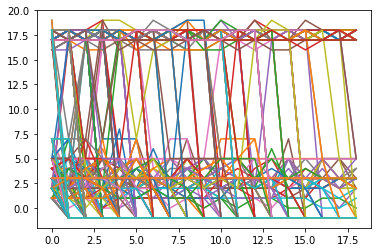

In [147]:
plotter = encode2.iloc[:,:20]
plotter = plotter.drop('index', axis = 1)
plotter[:500].T.plot(legend=None)

<AxesSubplot:>

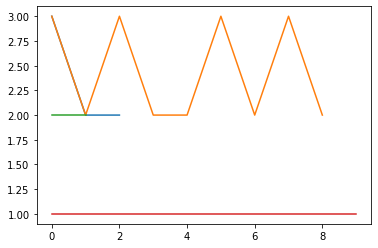

In [146]:
plotter1 = encode3.iloc[:,:20]
plotter1 = plotter1.drop('index', axis = 1)
plotter1[:10].T.plot(legend=None)

In [145]:
framed[:20]

,index,0,1,2,3,4,5,6,7,8,...,620,621,622,623,624,625,626,627,628,629
0,0,Page View,Product Viewed,Product Viewed,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,1,Page View,Product Viewed,Page View,Product Viewed,Product Viewed,Page View,Product Viewed,Page View,Product Viewed,...,None,None,None,None,None,None,None,None,None,None
2,2,Product Viewed,Product Viewed,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,3,Email Opened,Email Sent,Email Sent,Email Sent,Email Sent,Email Opened,Email Opened,Email Opened,Email Sent,...,None,None,None,None,None,None,None,None,None,None
4,4,Subscribe Clicked,Subscribe Clicked,Subscribe Clicked,Subscribe Clicked,Subscribe Clicked,Subscribe Clicked,Subscribe Clicked,Subscribe Clicked,Subscribe Clicked,...,None,None,None,None,None,None,None,None,None,None
5,5,Email Opened,Email Sent,Email Sent,Email Opened,Email Sent,Email Sent,None,None,None,...,None,None,None,None,None,None,None,None,None,None
6,6,Email Opened,Email Sent,Email Opened,Email Opened,Email Opened,Email Sent,Email Sent,Email Sent,Email Opened,...,None,None,None,None,None,None,None,None,None,None
7,7,Email Sent,Email Sent,Email Opened,Email Sent,Email Sent,Email Opened,Email Sent,Email Sent,Email Opened,...,None,None,None,None,None,None,None,None,None,None
8,8,Email Sent,Email Sent,Email Opened,Email Opened,Email Sent,Email Sent,Email Opened,Email Sent,None,...,None,None,None,None,None,None,None,None,None,None
9,9,Email Opened,Email Sent,Email Sent,Email Opened,Email Sent,Email Sent,Email Opened,Email Opened,Email Opened,...,None,None,None,None,None,None,None,None,None,None


In [85]:
def has_transact(row):
    for i in row:
        if i == 'Transaction Intent':
            return(1)
    return(0)

In [86]:
counts = framed.apply(has_transact, axis = 1)

In [139]:
counts[counts ==1]

43       1
44       1
100      1
105      1
106      1
        ..
71030    1
71180    1
71267    1
72180    1
72683    1
Length: 1222, dtype: int64

In [89]:
indices = counts.index[counts==1]

In [90]:
transacts = encode2.iloc[indices]

In [91]:
transacts

,index,0,1,2,3,4,5,6,7,8,...,620,621,622,623,624,625,626,627,628,629
43,43,3,3,3,3,3,3,3,3,3,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
44,44,2,2,2,1,0,1,1,3,3,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
100,100,1,2,2,0,2,2,2,3,2,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
105,105,2,2,2,1,1,3,2,2,5,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
106,106,2,2,2,3,3,3,3,3,3,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71030,71030,17,17,16,16,16,16,17,16,16,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
71180,71180,1,3,2,0,1,2,5,3,2,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
71267,71267,0,1,3,2,3,3,2,1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
72180,72180,18,18,0,0,0,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


<AxesSubplot:>

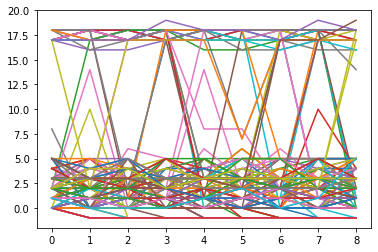

In [92]:
plot = transacts.iloc[:,:10]
plot = plot.drop('index', axis = 1)
plot[:200].T.plot(legend=None)

<AxesSubplot:>

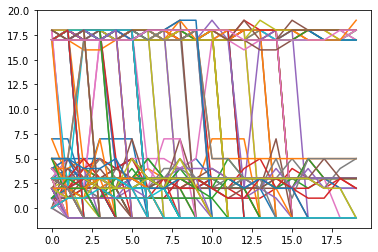

In [149]:
plotter = encode4.iloc[:,:20]
#plotter = plotter.drop('index', axis = 1)
plotter[:200].T.plot(legend=None)

In [105]:
counts1 = framed2.apply(has_transact, axis = 1)
indices1 = counts1.index[counts1==1]
transacts1 = encode4.iloc[indices]

<AxesSubplot:>

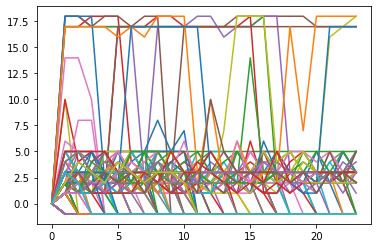

In [110]:
plot = transacts1.iloc[:,:25]
plot = plot.drop('index', axis = 1)
plot[:200].T.plot(legend=None)

In [107]:
transacts1

,index,0,1,2,3,4,5,6,7,8,...,620,621,622,623,624,625,626,627,628,629
43,43,0,3,3,3,2,3,3,3,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
44,44,0,2,1,1,1,2,1,1,3,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
100,100,0,2,2,2,3,2,3,2,2,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
105,105,0,5,3,3,3,3,3,2,2,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
106,106,0,2,3,3,3,3,3,3,3,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71030,71030,0,2,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
71180,71180,0,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
71267,71267,0,1,3,2,3,3,2,1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
72180,72180,0,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [117]:
framed2 = framed2.drop(['index'],axis =1)

In [129]:
transacts1= transacts1.drop('index', axis = 1)
transacts1

,0,1,2,3,4,5,6,7,8,9,...,620,621,622,623,624,625,626,627,628,629
43,0,3,3,3,2,3,3,3,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
44,0,2,1,1,1,2,1,1,3,3,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
100,0,2,2,2,3,2,3,2,2,2,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
105,0,5,3,3,3,3,3,2,2,2,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
106,0,2,3,3,3,3,3,3,3,3,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71030,0,2,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
71180,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
71267,0,1,3,2,3,3,2,1,1,3,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
72180,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>],
       [<AxesSubplot:title={'center':'3'}>,
        <AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>],
       [<AxesSubplot:title={'center':'6'}>,
        <AxesSubplot:title={'center':'7'}>,
        <AxesSubplot:title={'center':'8'}>],
       [<AxesSubplot:title={'center':'9'}>,
        <AxesSubplot:title={'center':'10'}>, <AxesSubplot:>]],
      dtype=object)

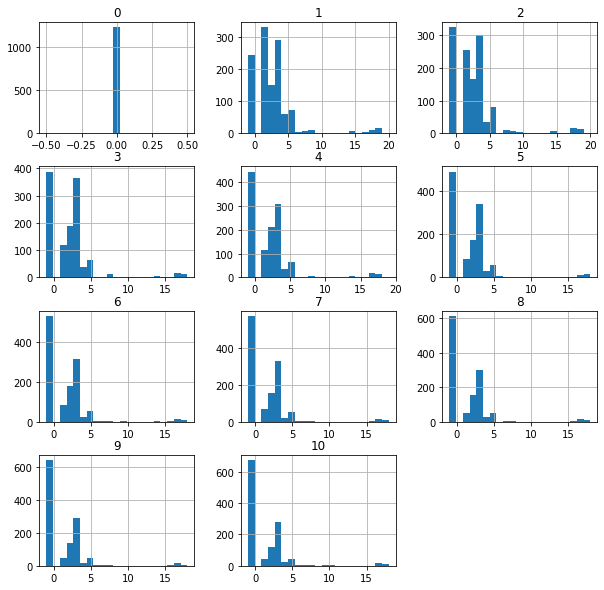

In [130]:

transacts1.loc[:,:10].hist(bins = 21, figsize = (10,10))

In [132]:
encode4 = encode4.drop('index',axis =1)

<AxesSubplot:ylabel='Frequency'>

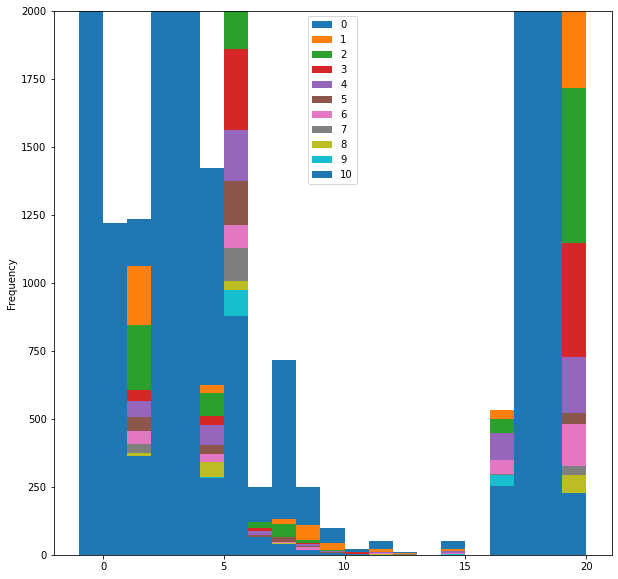

In [135]:
encode4.loc[:,:10].plot.hist(bins = 21, figsize= (10,10),ylim = (0,2000))

### Simple Event Tracking

In [114]:
complexTableGrouped = complexTableEvolution.groupby(['USER_ID']).aggregate(lambda tdf: tdf.tolist()).reset_index()

In [115]:
complexData = simpleUserInteraction(complexTableGrouped)

In [116]:
complexDataNoCais = pd.merge(complexData, emailDF, how= 'inner', left_on = 'USER_ID', right_on = 'USER_ID')

In [117]:
complexDataNoCais

,USER_ID,TIME,EVENT,JSON,Num Logins,Num Clicks,ID,EMAIL,FULL_NAME
0,10001,"[2021-05-09 02:16:01.228000, 2021-05-09 02:16:...","[Signed In, Page View, Page View, Product View...","[{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java""...",14,117,10001,skonig@talismanalliance.com,Salomon Konig
1,10009,"[2021-07-16 17:29:47.071000, 2021-07-16 17:30:...","[Signed In, Page View, Page View, Page View, P...","[{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java""...",19,121,10009,bluthy@rwbaird.com,Bill Luthy
2,10013,"[2021-04-09 13:42:53.575000, 2021-04-13 12:45:...","[Page View, Page View, Page View, Page View, P...","[{\n ""ANONYMOUS_ID"": ""4b8d01b8-15dc-47fb-ba54...",32,336,10013,lkittelson@rwbaird.com,Lynn Kittelson
3,10014,"[2021-04-09 18:36:10.019000, 2021-04-09 18:51:...","[Page View, Page View, Page View, Page View, P...","[{\n ""ANONYMOUS_ID"": ""3dee2da1-ef72-4b77-a824...",69,657,10014,gdlannen@synergycapitalsolutions.com,Gary Lannen
4,10015,"[2021-07-29 15:56:20.910000, 2021-07-29 15:56:...","[Signed In, Page View, Page View, Page View, S...","[{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java""...",7,33,10015,debra@mosaicwealth.com,Debra Hart
...,...,...,...,...,...,...,...,...,...
7452,9994,"[2021-04-15 14:17:32.404000, 2021-04-15 14:17:...","[Page View, Page View, Page View, Page View, P...","[{\n ""ANONYMOUS_ID"": ""5b2e18b1-51f6-473f-aa2c...",13,143,9994,bgreenfeld@waldronpw.com,Benjamin Greenfeld
7453,9995,"[2021-09-16 15:20:49.054000, 2021-09-16 15:22:...","[Signed In, Page View, Page View, Signed In, P...","[{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java""...",9,77,9995,GFrey@WaldronPW.com,Garrett Frey
7454,9996,"[2021-05-13 12:48:14.762000, 2021-05-13 12:48:...","[Signed In, Page View, Page View, Page View, P...","[{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java""...",72,505,9996,sreilly@gylfinsyn.com,Shane Reilly
7455,9997,"[2021-04-30 00:17:13.453000, 2021-04-30 00:17:...","[Signed In, Page View, Page View, Page View, P...","[{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java""...",11,89,9997,jjiao@taipartners.net,James Jiao


### Login but No Click Analysis

In [118]:
noClicks = complexDataNoCais.loc[complexDataNoCais['Num Clicks'] == 0]
print(len(pd.unique(noClicks['USER_ID'])))
print(len(pd.unique(complexDataNoCais['USER_ID'])))
noClicks

87
7457


,USER_ID,TIME,EVENT,JSON,Num Logins,Num Clicks,ID,EMAIL,FULL_NAME
49,10131,[2021-06-21 12:47:00.729000],[Signed In],"[{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java""...",1,0,10131,dsandahl@rwbaird.com,Doug Sandahl
187,10500,[2021-07-20 18:41:22.817000],[Signed In],"[{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java""...",1,0,10500,zrioux@innovationpartnersllc.com,Zachary Rioux
216,10592,[2022-05-23 15:29:05.513000],[Signed In],"[{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java""...",1,0,10592,james.hastings@hightoweradvisors.com,James Hastings
314,10839,[2022-01-13 20:24:46.865000],[Signed In],"[{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java""...",1,0,10839,matt@soltisadvisors.com,Matt Brann
516,11432,"[2021-12-22 22:29:36.891000, 2021-12-22 22:29:...","[Signed In, Signed In]","[{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java""...",2,0,11432,Sebastian.Granzo@Evercore.com,Sebastian Granzo
...,...,...,...,...,...,...,...,...,...
6511,7150,"[2021-09-12 01:11:53.289000, 2022-05-25 05:16:...","[Signed In, Signed In]","[{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java""...",2,0,7150,JHedin@pgoc.com.au,Jill Hedin
6512,7155,"[2021-08-31 15:56:33.986000, 2021-09-22 21:25:...","[Signed In, Signed In, Signed In]","[{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java""...",3,0,7155,Brackmann@axxcesswealth.com,Jon Brackmann
6518,7177,[2021-10-05 20:36:58.286000],[Signed In],"[{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java""...",1,0,7177,johnjenkins@asset-preservation.com,John Jenkins
6564,7351,[2022-06-08 13:41:31.182000],[Signed In],"[{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java""...",1,0,7351,larry@cen-wealth.com,Larry Flynn


In [119]:
len(noClicks)/len(complexDataNoCais)

0.011666890170309776

In [120]:
fewLogins = noClicks.loc[noClicks['Num Logins']>1]
len(fewLogins)

15

In [121]:
len(fewLogins)/len(complexDataNoCais)

0.002011532787984444

In [122]:
noClicks.sort_values(by='Num Logins', ascending = False)

,USER_ID,TIME,EVENT,JSON,Num Logins,Num Clicks,ID,EMAIL,FULL_NAME
979,12800,"[2021-06-15 12:40:27.149000, 2021-06-22 13:07:...","[Signed In, Signed In, Signed In, Signed In, S...","[{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java""...",17,0,12800,STEPHEN.WADLINGER@nm.com,Stephen Wadlinger
1009,12967,"[2021-06-23 18:24:55.530000, 2021-06-24 15:26:...","[Signed In, Signed In, Signed In, Signed In, S...","[{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java""...",11,0,12967,THOMAS.G.WILDER@nm.com,Thomas Wilder
1609,16318,"[2021-06-25 13:00:44.946000, 2021-06-25 15:11:...","[Signed In, Signed In, Signed In, Signed In, S...","[{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java""...",5,0,16318,MATTHEWPRITCHARD@northwesternmutual.com,Matthew Pritchard
1985,17087,"[2021-10-11 13:55:57.048000, 2021-10-11 14:19:...","[Signed In, Signed In, Signed In, Signed In]","[{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java""...",4,0,17087,JoePossing@northwesternmutual.com,Joseph Possing
6512,7155,"[2021-08-31 15:56:33.986000, 2021-09-22 21:25:...","[Signed In, Signed In, Signed In]","[{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java""...",3,0,7155,Brackmann@axxcesswealth.com,Jon Brackmann
...,...,...,...,...,...,...,...,...,...
2599,19020,[2022-03-07 20:28:24.277000],[Signed In],"[{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java""...",1,0,19020,dfrazier@merceradvisors.com,Danielle Frazier
2598,19019,[2022-04-19 23:11:31.244000],[Signed In],"[{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java""...",1,0,19019,csmith@merceradvisors.com,Caitlin Smith
2574,18978,[2021-10-28 20:45:44.821000],[Signed In],"[{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java""...",1,0,18978,msheets@merceradvisors.com,Matthew Sheets
2567,18964,[2021-07-12 19:04:55.624000],[Signed In],"[{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java""...",1,0,18964,lameslyons@merceradvisors.com,Linda Ames Lyons


In [123]:
user_slice(complexTable,'9379')

,USER_ID,TIME,EVENT,JSON
1274382,9379,2021-04-20 15:26:12.539,Signed In,"{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java"",..."
1274402,9379,2021-04-20 15:26:28.849,Signed In,"{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java"",..."
746911,9379,2021-04-20 22:36:24.999,Signed In,"{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java"",..."
1849663,9379,2021-04-20 22:57:53.813,Document Downloaded,"{\n ""CATEGORY"": ""5"",\n ""CONTENT_TYPE"": ""appl..."
480403,9379,2021-04-22 21:58:05.084,Signed In,"{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java"",..."
...,...,...,...,...
1861492,9379,2022-06-23 23:12:27.965,Document Downloaded,"{\n ""CATEGORY"": ""5"",\n ""CONTENT_TYPE"": ""appl..."
1306197,9379,2022-06-23 23:19:52.207,Signed In,"{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java"",..."
1861504,9379,2022-06-23 23:20:31.295,Document Downloaded,"{\n ""CATEGORY"": ""5"",\n ""CONTENT_TYPE"": ""appl..."
1845030,9379,2022-06-28 19:55:28.179,Signed In,"{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java"",..."


### End Login No Click Analysis

In [127]:
tupleJourney = create_simple_tuple_journey(complexTableNoCais)
tupleJourney

,USER_ID,Journey
0,11044,"[(2021-04-08 22:51:36.903000, Page View, {\n ..."
1,6668,"[(2021-04-08 23:03:05.425000, Page View, {\n ..."
2,16201,"[(2021-04-08 23:05:09.267000, Page View, {\n ..."
3,16709,"[(2021-04-08 23:10:33.968000, Page View, {\n ..."
4,4033,"[(2021-04-08 23:11:58.213000, Page View, {\n ..."
...,...,...
7452,25050,"[(2022-08-02 15:16:11.058000, Page View, {\n ..."
7453,26796,"[(2022-08-02 15:33:29.107000, Signed In, {\n ..."
7454,26798,"[(2022-08-02 15:47:57.793000, Account Created,..."
7455,26799,"[(2022-08-02 17:03:57.082000, Signed In, {\n ..."


In [129]:
readable_user_journey(tupleJourney, '16709')

User 16709 Interaction Summary: 6 login(s) and 35 click(s).
User Journey 
Page View at 2021-04-08 23:10:33.968000
Page View at 2021-04-08 23:10:40.786000
Page View at 2021-04-08 23:10:56.797000
Page View at 2021-04-08 23:11:25.455000
Page View at 2021-04-08 23:11:41.999000
Page View at 2021-04-08 23:12:07.842000
Page View at 2021-04-08 23:12:10.845000
Page View at 2021-04-08 23:12:15.642000
Login at 2021-06-26 07:24:54.423000
Page View at 2021-06-26 07:25:06.050000
Page View at 2021-06-26 07:26:51.709000
Page View at 2021-06-26 07:27:10.698000
Product Viewed at 2021-06-26 07:27:45.641000
Page View at 2021-06-26 07:27:45.682000
Page View at 2021-06-26 07:28:18.151000
Page View at 2021-06-26 07:28:36.923000
Page View at 2021-06-26 07:33:02.010000
Page View at 2021-06-26 07:33:02.902000
Document Downloaded at 2021-06-26 07:33:04.466000
Page View at 2021-06-26 07:33:22.875000
Page View at 2021-06-26 07:33:56.065000
Page View at 2021-06-26 07:34:39.261000
Login at 2021-06-29 08:16:38.117000

In [26]:
#loginSessions = session_view_login(tupleJourney)

In [71]:
#loginSessions

In [28]:
dailySessions = session_view_daily(tupleJourney)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067


3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712


5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354


6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000


In [129]:
dailySessions = dailySessions.drop(dailySessions[dailySessions['Session Number'] ==0].index)

Text(0.5, 1.0, 'Daily Sessions: Analysis')

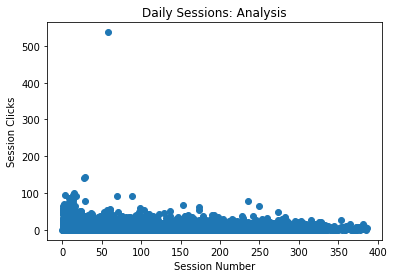

In [30]:
plt.scatter(dailySessions['Session Number'], dailySessions['Session Clicks'])
plt.xlabel('Session Number')
plt.ylabel('Session Clicks')
plt.title('Daily Sessions: Analysis')

In [31]:
dailySessions.loc[dailySessions['Session Clicks']>200]

,User ID,Session Number,Session Start Time,Session End Time,Session Duration,Session Clicks,Session Logins,More Info
83262,19729,58.0,2022-01-09 01:36:25,2022-01-09 18:47:39,0 days 17:11:14,537.0,426.0,"[{\n ""ANONYMOUS_ID"": ""c7f054ff-0bad-41b2-a061..."


In [32]:
dailySessionsNoOutlier = dailySessions.drop(index = 82111)

Text(0.5, 1.0, 'Daily Sessions: Analysis')

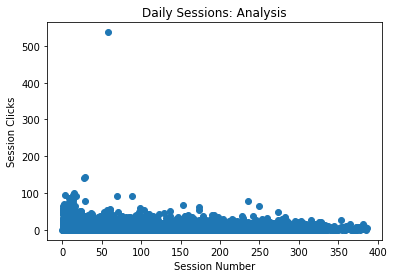

In [33]:
plt.scatter(dailySessionsNoOutlier['Session Number'], dailySessionsNoOutlier['Session Clicks'])
plt.xlabel('Session Number')
plt.ylabel('Session Clicks')
plt.title('Daily Sessions: Analysis')

In [34]:
dailySessions['Session Duration'] = dailySessions['Session Duration'].astype('timedelta64[s]')
dailySessions['Session Duration'] = dailySessions['Session Duration'].values.astype(np.int64)

Text(0.5, 1.0, 'Daily Sessions: Analysis')

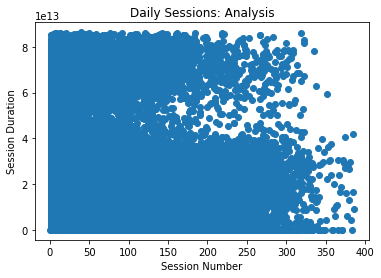

In [35]:
plt.scatter(dailySessions['Session Number'], dailySessions['Session Duration'])
plt.xlabel('Session Number')
plt.ylabel('Session Duration')
plt.title('Daily Sessions: Analysis')

In [127]:
dailySessions[dailySessions['Session Number']==0]

,User ID,Session Number,Session Start Time,Session End Time,Session Duration,Session Clicks,Session Logins,More Info
41306,None,0.0,0,0,0,0.0,0.0,No activity for this user yet.


(array([7748.,    0.,    0.,    0.,    0.,    0.,    0.,    0., 5491.,
           0.,    0.,    0.,    0., 4446.,    0.,    0.,    0., 3865.,
           0.,    0., 3440.,    0., 3103.,    0., 2831.,    0., 2630.,
        2451., 2285.,    0., 2134., 2006., 1896., 1807., 3339., 1538.,
        1473., 2728., 2505., 1189., 2257., 3129., 1937., 1807., 2518.,
        2323., 2117., 2521., 1737., 2646., 1931., 2190., 1962., 1775.,
        1958., 2067., 1806., 1829., 1628., 1615., 1414., 1453., 1180.,
        1226., 1074.,  985.,  879.,  799.,  716.,  631.,  499.,  305.,
         142.,   46.,   30.]),
 array([0.        , 0.07941116, 0.15882233, 0.23823349, 0.31764466,
        0.39705582, 0.47646699, 0.55587815, 0.63528932, 0.71470048,
        0.79411165, 0.87352281, 0.95293398, 1.03234514, 1.11175631,
        1.19116747, 1.27057864, 1.3499898 , 1.42940097, 1.50881213,
        1.5882233 , 1.66763446, 1.74704563, 1.82645679, 1.90586796,
        1.98527912, 2.06469029, 2.14410145, 2.22351262, 2.302

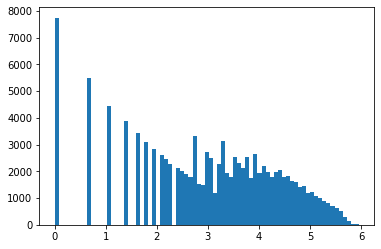

In [130]:
plt.hist(np.log(dailySessions['Session Number']), bins = 75)

In [37]:
dailySessions.loc[dailySessions['Session Duration']<1000]

,User ID,Session Number,Session Start Time,Session End Time,Session Duration,Session Clicks,Session Logins,More Info
10,11044,11.0,2021-05-21 17:54:01,2021-05-21 17:54:01,0,0.0,1.0,"[{\n ""ANONYMOUS_ID"": ""b758c934-3954-4901-b983..."
32,11044,33.0,2021-10-06 16:07:06,2021-10-06 16:07:06,0,0.0,1.0,"[{\n ""ANONYMOUS_ID"": ""b758c934-3954-4901-b983..."
63,17067,24.0,2021-05-14 14:06:24,2021-05-14 14:06:24,0,0.0,1.0,"[{\n ""ANONYMOUS_ID"": ""365ce853-f643-4316-92e3..."
76,17067,37.0,2021-06-03 17:33:39,2021-06-03 17:33:39,0,0.0,1.0,"[{\n ""ANONYMOUS_ID"": ""365ce853-f643-4316-92e3..."
96,17067,57.0,2021-07-02 19:08:27,2021-07-02 19:08:27,0,0.0,1.0,"[{\n ""ANONYMOUS_ID"": ""365ce853-f643-4316-92e3..."
...,...,...,...,...,...,...,...,...
111966,6518,1.0,2022-07-15 14:57:34,2022-07-15 14:57:34,0,0.0,1.0,"[{\n ""ANONYMOUS_ID"": ""7f96e15f-1596-4711-aafb..."
111976,26526,2.0,2022-07-19 17:46:40,2022-07-19 17:46:40,0,0.0,1.0,"[{\n ""ANONYMOUS_ID"": ""d22c2168-a317-4bcf-8d45..."
111981,26530,1.0,2022-07-18 13:41:17,2022-07-18 13:41:17,0,0.0,1.0,"[{\n ""ANONYMOUS_ID"": ""8e4b3b50-9c27-4a19-9991..."
112011,12482,1.0,2022-07-19 03:21:33,2022-07-19 03:21:33,0,0.0,1.0,"[{\n ""ANONYMOUS_ID"": ""0eb94b6d-b2ca-4655-a69f..."


In [38]:
keyDictionary = {
    "Subscribe Clicked":['IS_CAIS_FUND', 'MERCER_RATING', 'PRODUCT_TYPE', 'STRATEGY','SUB_STRATEGY'],
    "Document Downloaded":[],
    "Product Viewed":[],
    "Product Video Clicked":[],
    "Pages":[]
}

### Begin Holdings Work

In [36]:
emailDF

,ID,EMAIL,FULL_NAME
0,10013,lkittelson@rwbaird.com,Lynn Kittelson
1,12366,BRIANKERTSCHER@northwesternmutual.com,Brian Kertscher
2,18853,hrios@rwbaird.com,Heriberto Rios
3,19574,Frederick.Kienel@truist.com,Frederick Kienel
4,10972,chris.gure@fortressfp.com,Chris Gure
...,...,...,...
7473,4417,zoe.yan@macquarie.com,Zoe Yan
7474,5690,ben@trekfinancial.com,Ben Bimson
7475,18851,johns@legacycapitalwp.com,John Sidery
7476,11825,MARKPILLING@northwesternmutual.com,MARK PILLING


In [38]:
df = see_most_viewed_pages_full(portalConn)

In [39]:
df["TITLE"].value_counts()

CAIS                                                                  455054
Dashboard                                                             309548
Login | CAIS                                                          281402
Pipeline                                                              136285
PDF Viewer | CAIS                                                     106084
                                                                       ...  
6169_SubAck_7878_01012019.pdf                                              1
CAIS | Executive Investment Roundtable - Intelligence & Insights           1
Mercer Hedge Fund Update, Q4 - Intelligence & Insights                     1
CAIS.pdf                                                                   1
Subscription Document-DS13260017-OTHER THINGS LLC_Rev(10_2_19).pdf         1
Name: TITLE, Length: 102, dtype: int64

In [40]:
scrub = pd.merge(df, emailDF, how= 'inner', left_on = 'USER_ID', right_on = 'USER_ID')

In [41]:
scrub['TITLE'].value_counts()

CAIS                                                                                               309408
Dashboard                                                                                          194518
Login | CAIS                                                                                       161881
Pipeline                                                                                           114536
PDF Viewer | CAIS                                                                                   82625
Holdings - CAIS                                                                                     48220
Alternative Investments                                                                             20664
Select Funds                                                                                        19963
Education                                                                                            8077
download                                      

In [43]:
yoyo = get_user_and_firm_info(portalConn)

In [44]:
yoyo.sort_values(by = 'FIRM_FULL_NAME')

,ID,EMAIL,FULL_NAME,FIRM_ID,FIRM_FULL_NAME
1841,23942,nick.cianci@musecapitalmgmt.com,Nicholas Cianci,113129,Muse Capital Management LLC
1694,11781,srhodes@signifywealth.com,Stephen Rhodes,112392,Signify Wealth LLC
6788,20377,lorenzo@1010capital.com.au,Lorenzo Lizza,112771,1010 Capital
6787,19671,dale@1010capital.com.au,Dale Sanftl,112771,1010 Capital
947,20490,johnm@103advisory.com,John Mariscalco,112808,103 Advisory Group
...,...,...,...,...,...
378,9845,hemant@eplanetcapital.com,Hemant Khatwani,112036,ePlanet Capital
5837,2329,janetnguyen@theiim.com,Janet Nguyen,47,iim
289,11494,marie.santangelo@myciowp.com,Marie Santangelo,112129,myCIO Wealth Partners LLC
288,10307,michael.finelli@myciowp.com,Michael Finelli,112129,myCIO Wealth Partners LLC


In [46]:
holdingViews = get_holding_page_view_info(portalConn)

In [47]:
holdingViews

,REFERRER,TITLE,USER_ID,URL
0,https://members.caisgroup.com/platform/reports,Holdings - CAIS,3832,https://members.caisgroup.com/cais-accounts/ho...
1,https://members.caisgroup.com/,Holdings - CAIS,7900,https://members.caisgroup.com/cais-accounts
2,https://members.caisgroup.com/platform/alterna...,Holdings - CAIS,8831,https://members.caisgroup.com/cais-accounts
3,https://members.caisgroup.com/investment-pipel...,Holdings - CAIS,17068,https://members.caisgroup.com/cais-accounts/ho...
4,https://members.caisgroup.com/,Holdings - CAIS,11046,https://members.caisgroup.com/cais-accounts
...,...,...,...,...
75479,https://members.caisgroup.com/snapshot,Holdings - CAIS,7544,https://members.caisgroup.com/cais-accounts/ho...
75480,https://members.caisgroup.com/,Holdings - CAIS,23369,https://members.caisgroup.com/cais-accounts/ho...
75481,https://members.caisgroup.com/,Holdings - CAIS,9695,https://members.caisgroup.com/cais-accounts
75482,https://members.caisgroup.com/,Holdings - CAIS,4356,https://members.caisgroup.com/cais-accounts


In [48]:
merged = pd.merge(yoyo, holdingViews, how= "left", left_on = 'ID', right_on = 'USER_ID')

In [49]:
merged

,ID,EMAIL,FULL_NAME,FIRM_ID,FIRM_FULL_NAME,REFERRER,TITLE,USER_ID,URL
0,26620,cjkoehn@waterstreetfin.com,Charlie Koehn,113361,Advisory Services Network,NaN,NaN,NaN,NaN
1,10363,Ben.Napier@captrust.com,Ben Napier,112141,CapTrust Financial Advisors (Austin),https://members.caisgroup.com/,Holdings - CAIS,10363,https://members.caisgroup.com/cais-accounts
2,10092,BCLark@headinvest.com,Ben Clark,112093,HeadInvest,NaN,NaN,NaN,NaN
3,19564,cgrillo@linscomb-williams.com,Corbin Grillo,112749,Linscomb and Williams,https://members.caisgroup.com/investment-pipel...,Holdings - CAIS,19564,https://members.caisgroup.com/cais-accounts
4,20952,m.merl1327@gmail.com,Mark Merl,112861,AWS Migration,https://members.caisgroup.com/investment-pipel...,Holdings - CAIS,20952,https://members.caisgroup.com/cais-accounts
...,...,...,...,...,...,...,...,...,...
51721,10411,mduffy@bogartwealth.com,Mike Duffy,112155,Bogart Wealth,https://members.caisgroup.com/investment-pipel...,Holdings - CAIS,10411,https://members.caisgroup.com/cais-accounts
51722,10411,mduffy@bogartwealth.com,Mike Duffy,112155,Bogart Wealth,https://members.caisgroup.com/platform/structu...,Holdings - CAIS,10411,https://members.caisgroup.com/cais-accounts
51723,10411,mduffy@bogartwealth.com,Mike Duffy,112155,Bogart Wealth,https://members.caisgroup.com/cais-accounts/ho...,Holdings - CAIS,10411,https://members.caisgroup.com/cais-accounts
51724,10411,mduffy@bogartwealth.com,Mike Duffy,112155,Bogart Wealth,https://members.caisgroup.com/platform/alterna...,Holdings - CAIS,10411,https://members.caisgroup.com/cais-accounts


In [50]:
powerCompanies = merged.value_counts('FIRM_FULL_NAME')

In [51]:
powerCompanies

FIRM_FULL_NAME
Robert W. Baird & Co.                   6279
Truist Investment Services              4646
Northwestern Mutual                     3542
The Colony Group, LLC                   2279
HighTower Advisors                      1828
                                        ... 
Diversified Financial Management           1
Nicollet Investment Management, Inc.       1
Dightman Capital Group                     1
NorthCoast Asset Management                1
 Muse Capital Management LLC               1
Length: 1540, dtype: int64

In [105]:
powerCompanyList = merged.groupby('FIRM_FULL_NAME').aggregate(lambda tdf: tdf.to_list()).reset_index()
powerCompanyList['Holding Tab Views'] = powerCompanyList.ID.apply(lambda x: len(x))
#powerCompanyList['ID'] = powerCompanyList.ID.apply(lambda x: x[0])
powerCompanyList['EMAIL'] = powerCompanyList.EMAIL.apply(lambda x: x[0])
powerCompanyList['FIRM_ID'] = powerCompanyList.FIRM_ID.apply(lambda x: x[0])
powerCompanyList = powerCompanyList.drop(['FULL_NAME','ID','REFERRER','TITLE','USER_ID','URL','Prior Page'], axis =1)
powerCompanyList = powerCompanyList.sort_values(by='Holding Tab Views', ascending = False)

In [107]:
powerCompanyList.to_csv('Holdings Tab Usage.csv')

In [59]:
powerIndividuals = merged.value_counts('FULL_NAME')
powerIndividuals

FULL_NAME
Keith Johnson       353
Laura Wimberly      329
Reporting Team      312
Felipe Mendonca     275
Amanda Zuhse        255
                   ... 
John Grubbs           1
John Grobmyer         1
John Griffis          1
Brander Richmond      1
A.J. Shoemaker        1
Length: 7119, dtype: int64

In [60]:
powerIndividuals[:15]

FULL_NAME
Keith Johnson            353
Laura Wimberly           329
Reporting Team           312
Felipe Mendonca          275
Amanda Zuhse             255
Laura Macias             251
Janeanne  Gregg          240
Demo Advisor             234
Jim Lynch                231
Adam Piraino             214
Paul Dryden              202
Gregory Sommersberger    198
Natalie Wang             197
Adam Ennis               195
Eugenia Kalaitzidis      187
dtype: int64

In [103]:
powerIndividualList = merged.groupby('FULL_NAME').aggregate(lambda tdf: tdf.to_list()).reset_index()
powerIndividualList['Holding Tab Views'] = powerIndividualList.REFERRER.apply(lambda x: len(x))
powerIndividualList['EMAIL'] = powerIndividualList.EMAIL.apply(lambda x: x[0])
powerIndividualList['FIRM_FULL_NAME'] = powerIndividualList['FIRM_FULL_NAME'].apply(lambda x: x[0])
powerIndividualList['FIRM_ID'] = powerIndividualList.FIRM_ID.apply(lambda x: x[0])
powerIndividualList['USER_ID'] = powerIndividualList.USER_ID.apply(lambda x: x[0])
powerIndividualList = powerIndividualList.drop(['ID','REFERRER','TITLE','URL','Prior Page'], axis =1)
powerIndividualList = powerIndividualList.sort_values(by='Holding Tab Views', ascending = False)

In [108]:
powerIndividualList.to_csv('Holdings Individuals.csv')

In [53]:
#where do they come from?

In [55]:
merged["Prior Page"] = merged['REFERRER'].apply(lambda row: high_level_track(row))

In [56]:
merged

,ID,EMAIL,FULL_NAME,FIRM_ID,FIRM_FULL_NAME,REFERRER,TITLE,USER_ID,URL,Prior Page
0,26620,cjkoehn@waterstreetfin.com,Charlie Koehn,113361,Advisory Services Network,NaN,NaN,NaN,NaN,Unknown
1,10363,Ben.Napier@captrust.com,Ben Napier,112141,CapTrust Financial Advisors (Austin),https://members.caisgroup.com/,Holdings - CAIS,10363,https://members.caisgroup.com/cais-accounts,Dashboard
2,10092,BCLark@headinvest.com,Ben Clark,112093,HeadInvest,NaN,NaN,NaN,NaN,Unknown
3,19564,cgrillo@linscomb-williams.com,Corbin Grillo,112749,Linscomb and Williams,https://members.caisgroup.com/investment-pipel...,Holdings - CAIS,19564,https://members.caisgroup.com/cais-accounts,Pipeline
4,20952,m.merl1327@gmail.com,Mark Merl,112861,AWS Migration,https://members.caisgroup.com/investment-pipel...,Holdings - CAIS,20952,https://members.caisgroup.com/cais-accounts,Pipeline
...,...,...,...,...,...,...,...,...,...,...
51721,10411,mduffy@bogartwealth.com,Mike Duffy,112155,Bogart Wealth,https://members.caisgroup.com/investment-pipel...,Holdings - CAIS,10411,https://members.caisgroup.com/cais-accounts,Pipeline
51722,10411,mduffy@bogartwealth.com,Mike Duffy,112155,Bogart Wealth,https://members.caisgroup.com/platform/structu...,Holdings - CAIS,10411,https://members.caisgroup.com/cais-accounts,Products
51723,10411,mduffy@bogartwealth.com,Mike Duffy,112155,Bogart Wealth,https://members.caisgroup.com/cais-accounts/ho...,Holdings - CAIS,10411,https://members.caisgroup.com/cais-accounts,Holdings
51724,10411,mduffy@bogartwealth.com,Mike Duffy,112155,Bogart Wealth,https://members.caisgroup.com/platform/alterna...,Holdings - CAIS,10411,https://members.caisgroup.com/cais-accounts,Products


In [57]:
merged["Prior Page"].value_counts()

Dashboard    23867
Pipeline     11860
Products      6395
Unknown       4776
Holdings      3023
Login          752
Education      688
Profile        222
Reports        123
Settings        18
Users            2
Name: Prior Page, dtype: int64

In [62]:
ok = merged.loc[merged["Prior Page"]=="Unknown"]['REFERRER']

In [63]:
ok.isna().sum()

4681

In [64]:
merged.loc[49248]['REFERRER']

'https://members.caisgroup.com/'

In [65]:
#where do they go? where do they come from cotton-eyed-joe

In [67]:
holdingRefs = holdings_referrers(portalConn)

In [68]:
holdingRefs['TITLE'].value_counts()

CAIS                                                                                               20702
Login | CAIS                                                                                       15329
Pipeline                                                                                           12136
Dashboard                                                                                           5752
Holdings - CAIS                                                                                     4505
download                                                                                            3543
Alternative Investments                                                                             1995
Active | CAIS                                                                                       1713
CAIS Management Portal                                                                               638
PDF Viewer | CAIS                                      

### End Holdings Work

### Check out how many subscription clicked turns into real transactions

In [71]:
subClicks = get_subscribe_clicked(portalConn)

In [72]:
transactions = get_transactions(rawConn)

In [100]:
len(transactions)

9494

In [73]:
len(transactions)/len(subClicks)

0.415001967041133

In [74]:
combined = pd.concat([subClicks,transactions], ignore_index = True)

In [75]:
combined['USER_ID'] = combined['USER_ID'].astype(str)

In [76]:
combined.sort_values(by=['USER_ID', 'TIME'])

,USER_ID,STATUS,STRATEGY,SHORT_NAME,TIME,FUND_ID,EVENT_TEXT,FIRM_ID,FULL_NAME,INVESTMENTDATE,UPDATEDATE
31976,10009,NaN,NaN,NaN,2022-07-20 13:07:07.000,341,transaction,457.0,Bill Luthy,2022-09-01,2022-07-28 09:41:22
2127,10009,Open,Real Estate,Ares,2022-07-20 15:01:59.390,341,Subscribe Clicked,457.0,Bill Luthy,NaN,NaT
2126,10009,Open,Real Estate,Ares,2022-07-20 17:03:46.768,341,Subscribe Clicked,457.0,Bill Luthy,NaN,NaT
21037,10013,Open,Long / Short Equity,"Alkeon Capital, LLC",2021-04-23 13:49:58.540,313,Subscribe Clicked,457.0,Lynn Kittelson,NaN,NaT
21035,10013,Open,Long / Short Equity,"Alkeon Capital, LLC",2021-09-17 19:01:14.560,313,Subscribe Clicked,457.0,Lynn Kittelson,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...
2971,9984,Open,Private Debt,Monroe Capital LLC,2022-07-28 17:47:15.553,312,Subscribe Clicked,112019.0,Kimberly Nitz,NaN,NaT
3009,9984,Open,Private Debt,Apollo,2022-07-29 13:10:26.473,487,Subscribe Clicked,112019.0,Kimberly Nitz,NaN,NaT
27442,9994,NaN,NaN,NaN,2022-01-13 16:06:20.000,417,transaction,110356.0,Benjamin Greenfeld,2022-02-01,2022-01-20 08:26:28
27731,9994,NaN,NaN,NaN,2022-01-27 14:29:14.000,393,transaction,110356.0,Benjamin Greenfeld,2022-04-06,2022-03-22 09:52:06


In [77]:
grouped = combined.groupby(['USER_ID','FUND_ID']).aggregate(lambda tdf: tdf.tolist()).reset_index()

In [78]:
grouped

,USER_ID,FUND_ID,STATUS,STRATEGY,SHORT_NAME,TIME,EVENT_TEXT,FIRM_ID,FULL_NAME,INVESTMENTDATE,UPDATEDATE
0,10009,341,"[Open, Open, nan]","[Real Estate, Real Estate, nan]","[Ares , Ares , nan]","[2022-07-20 17:03:46.768000, 2022-07-20 15:01:...","[Subscribe Clicked, Subscribe Clicked, transac...","[457.0, 457.0, 457.0]","[Bill Luthy, Bill Luthy, Bill Luthy]","[nan, nan, 2022-09-01]","[NaT, NaT, 2022-07-28 09:41:22]"
1,10013,313,"[Open, Open, Open, Open, Open]","[Long / Short Equity, Long / Short Equity, Lon...","[Alkeon Capital, LLC, Alkeon Capital, LLC, Alk...","[2021-09-17 19:01:14.560000, 2021-09-17 19:57:...","[Subscribe Clicked, Subscribe Clicked, Subscri...","[457.0, 457.0, 457.0, 457.0, 457.0]","[Lynn Kittelson, Lynn Kittelson, Lynn Kittelso...","[nan, nan, nan, nan, nan]","[NaT, NaT, NaT, NaT, NaT]"
2,10013,319,[Open],[Real Estate],[CIM Group],[2022-07-15 19:57:24.586000],[Subscribe Clicked],[457.0],[Lynn Kittelson],[nan],[NaT]
3,10014,319,"[Open, Open]","[Real Estate, Real Estate]","[CIM Group, CIM Group]","[2021-06-11 17:55:54.243000, 2021-06-10 14:34:...","[Subscribe Clicked, Subscribe Clicked]","[7.0, 7.0]","[Gary Lannen, Gary Lannen]","[nan, nan]","[NaT, NaT]"
4,10014,324,"[Open, Open, Open, Open, Open, Open, Open, Ope...","[Private Equity, Private Equity, Private Equit...","[Knightsbridge Advisors LLC, Knightsbridge Adv...","[2021-06-10 14:41:57.912000, 2021-06-10 14:46:...","[Subscribe Clicked, Subscribe Clicked, Subscri...","[7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, ...","[Gary Lannen, Gary Lannen, Gary Lannen, Gary L...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[NaT, NaT, NaT, NaT, NaT, NaT, NaT, NaT, NaT, ..."
...,...,...,...,...,...,...,...,...,...,...,...
6660,9984,404,"[Open, Open]","[Real Estate, Real Estate]","[Bridge Development Fund Manager LLC, Bridge D...","[2021-11-04 12:35:56.757000, 2021-11-04 12:28:...","[Subscribe Clicked, Subscribe Clicked]","[112019.0, 112019.0]","[Kimberly Nitz, Kimberly Nitz]","[nan, nan]","[NaT, NaT]"
6661,9984,487,"[Open, Open, Open, Open, Open, Open, Open]","[Private Debt, Private Debt, Private Debt, Pri...","[Apollo, Apollo, Apollo, Apollo, Apollo, Apoll...","[2022-06-23 19:32:45.702000, 2022-06-24 16:42:...","[Subscribe Clicked, Subscribe Clicked, Subscri...","[112019.0, 112019.0, 112019.0, 112019.0, 11201...","[Kimberly Nitz, Kimberly Nitz, Kimberly Nitz, ...","[nan, nan, nan, nan, nan, nan, nan]","[NaT, NaT, NaT, NaT, NaT, NaT, NaT]"
6662,9984,498,[Open],[Real Estate],"[Related Fund Management, LLC]",[2022-07-20 19:52:20.463000],[Subscribe Clicked],[112019.0],[Kimberly Nitz],[nan],[NaT]
6663,9994,393,[nan],[nan],[nan],[2022-01-27 14:29:14],[transaction],[110356.0],[Benjamin Greenfeld],[2022-04-06],[2022-03-22 09:52:06]


In [79]:
grouped.iloc[4]['EVENT_TEXT']

['Subscribe Clicked',
 'Subscribe Clicked',
 'Subscribe Clicked',
 'Subscribe Clicked',
 'Subscribe Clicked',
 'Subscribe Clicked',
 'Subscribe Clicked',
 'Subscribe Clicked',
 'Subscribe Clicked',
 'Subscribe Clicked',
 'Subscribe Clicked',
 'Subscribe Clicked',
 'Subscribe Clicked',
 'Subscribe Clicked',
 'Subscribe Clicked',
 'Subscribe Clicked',
 'Subscribe Clicked',
 'Subscribe Clicked',
 'Subscribe Clicked',
 'Subscribe Clicked',
 'Subscribe Clicked',
 'Subscribe Clicked']

In [80]:
mask = grouped['EVENT_TEXT'].apply(lambda x: 'transaction' in x)

In [81]:
grouped1 = grouped[mask]

In [82]:
grouped1

,USER_ID,FUND_ID,STATUS,STRATEGY,SHORT_NAME,TIME,EVENT_TEXT,FIRM_ID,FULL_NAME,INVESTMENTDATE,UPDATEDATE
0,10009,341,"[Open, Open, nan]","[Real Estate, Real Estate, nan]","[Ares , Ares , nan]","[2022-07-20 17:03:46.768000, 2022-07-20 15:01:...","[Subscribe Clicked, Subscribe Clicked, transac...","[457.0, 457.0, 457.0]","[Bill Luthy, Bill Luthy, Bill Luthy]","[nan, nan, 2022-09-01]","[NaT, NaT, 2022-07-28 09:41:22]"
7,10016,393,[nan],[nan],[nan],[2021-06-17 14:24:01],[transaction],[110230.0],[Anthony Chisolm ],[2021-08-01],[2021-07-20 11:55:39]
8,10022,448,"[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]","[2021-11-04 12:36:00, 2021-11-22 16:51:46, 202...","[transaction, transaction, transaction]","[7.0, 7.0, 7.0]","[David Zoll, David Zoll, David Zoll]","[2021-11-15, 2021-12-30, 2021-12-30]","[2021-11-15 11:44:17, 2021-11-29 11:56:31, 202..."
9,10041,313,[nan],[nan],[nan],[2021-05-12 13:41:07],[transaction],[457.0],[John Bradley],[2021-07-01],[2021-06-15 15:32:15]
10,10041,341,"[nan, nan, nan, nan]","[nan, nan, nan, nan]","[nan, nan, nan, nan]","[2022-05-10 11:21:10, 2022-06-13 10:38:04, 202...","[transaction, transaction, transaction, transa...","[457.0, 457.0, 457.0, 457.0]","[John Bradley, John Bradley, John Bradley, Joh...","[2022-06-01, 2022-08-01, 2022-07-01, 2022-09-01]","[2022-05-23 15:09:12, 2022-07-01 10:48:50, 202..."
...,...,...,...,...,...,...,...,...,...,...,...
6652,9959,356,[nan],[nan],[nan],[2022-03-16 10:00:31],[transaction],[315.0],[Laura-Min Proctor],[2022-04-01],[2022-04-04 20:57:47]
6654,9980,319,[nan],[nan],[nan],[2021-12-07 12:03:58],[transaction],[111579.0],[Alan Tarver],[2021-12-30],[2022-01-05 14:47:12]
6655,9980,326,[nan],[nan],[nan],[2021-12-07 12:03:14],[transaction],[111579.0],[Alan Tarver],[2021-12-30],[2021-12-17 12:41:05]
6663,9994,393,[nan],[nan],[nan],[2022-01-27 14:29:14],[transaction],[110356.0],[Benjamin Greenfeld],[2022-04-06],[2022-03-22 09:52:06]


In [83]:
tupleJourney

,USER_ID,Journey
0,11044,"[(2021-04-08 22:51:28.394000, Identify, {\n ""..."
1,6668,"[(2021-04-08 23:02:48.071000, Identify, {\n ""..."
2,16201,"[(2021-04-08 23:04:00.054000, Identify, {\n ""..."
3,16709,"[(2021-04-08 23:10:22.673000, Identify, {\n ""..."
4,4033,"[(2021-04-08 23:11:46.464000, Identify, {\n ""..."
...,...,...
7473,26796,"[(2022-08-02 15:33:29.107000, Signed In, {\n ..."
7474,26798,"[(2022-08-02 15:47:57.793000, Account Created,..."
7475,26797,"[(2022-08-02 16:35:55.077000, Identify, {\n ""..."
7476,26799,"[(2022-08-02 17:03:57.082000, Signed In, {\n ..."


In [420]:
#integrate more information
eventDictionary = {
    "Document Downloaded" : ['FILE_NAME'],
    "Page View": ['URL'],
    "Product Viewed": ['FUND_ID','SHORT_NAME'],
    'Product Video Clicked': ['FUND_ID','SHORT_NAME'],
    "Subscribe Clicked" : ['FUND_ID','SHORT_NAME'],
    "Structured Product Viewed": ['PRODUCT_ID', 'UNDERLYING'],
    "Webinar Attended": ['FUND_ID', 'EVENT_NAME','FUND_MANAGER','LIVEMINUTES']
    
}

In [280]:
eventFrame = get_last_n_events(tupleJourney,3,eventDictionary)

In [287]:
eventFrame.loc[12]

Times            [2021-12-17 21:10:47.406000, 2021-12-17 21:10:...
Events           [Page View, Product Viewed, Page View, Subscri...
Detailed Info    [[(None, https://members.caisgroup.com/platfor...
Full Info        [{\n  "ANONYMOUS_ID": "6cbc67f0-3e41-4725-aaeb...
USERID                                                       11516
Name: 12, dtype: object

In [276]:
user_slice(complexTable, '26723')

,USER_ID,TIME,EVENT,JSON
268293,26723,2022-07-28 19:19:12.150,Account Created,"{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java"",..."
784933,26723,2022-07-29 13:07:20.387,Signed In,"{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java"",..."
2073397,26723,2022-07-29 13:07:21.386,Page View,"{\n ""ANONYMOUS_ID"": ""bba36efd-711e-467d-b96e-..."
2073271,26723,2022-07-29 13:07:29.269,Page View,"{\n ""ANONYMOUS_ID"": ""bba36efd-711e-467d-b96e-..."
2073362,26723,2022-07-29 13:07:50.860,Page View,"{\n ""ANONYMOUS_ID"": ""bba36efd-711e-467d-b96e-..."
...,...,...,...,...
745209,26723,2022-07-29 14:01:05.823,Page View,"{\n ""ANONYMOUS_ID"": ""bba36efd-711e-467d-b96e-..."
1084536,26723,2022-07-29 14:02:27.820,Subscribe Clicked,"{\n ""ANONYMOUS_ID"": ""bba36efd-711e-467d-b96e-..."
745386,26723,2022-07-29 14:02:28.019,Page View,"{\n ""ANONYMOUS_ID"": ""bba36efd-711e-467d-b96e-..."
1080974,26723,2022-07-29 14:02:32.822,Product Viewed,"{\n ""ANONYMOUS_ID"": ""bba36efd-711e-467d-b96e-..."


In [69]:
readable_user_journey(tupleJourney, '26723')

User 26723 Interaction Summary: 19 login(s) and 589 event(s).
User Journey 
Email Sent at 2022-07-19 13:00:55.807000
Email Sent at 2022-07-23 09:01:22.911000
Email Sent at 2022-07-25 09:00:47.810000
Email Sent at 2022-07-26 11:01:02.628000
Email Sent at 2022-07-27 09:00:39.595000
Email Sent at 2022-07-28 10:02:08.561000
Account Created at 2022-07-28 19:19:12.150000
Email Sent at 2022-07-29 08:03:01.149000
Login at 2022-07-29 13:07:20.387000
Page View at 2022-07-29 13:07:21.386000
Page View at 2022-07-29 13:07:29.269000
Page View at 2022-07-29 13:07:50.860000
Page View at 2022-07-29 13:08:23.405000
Page View at 2022-07-29 13:08:27.028000
Page View at 2022-07-29 13:08:52.601000
Product Viewed at 2022-07-29 13:09:16.042000
Page View at 2022-07-29 13:09:35.709000
Page View at 2022-07-29 13:09:36.834000
Page View at 2022-07-29 13:09:37.492000
Document Downloaded at 2022-07-29 13:09:38.888000
Page View at 2022-07-29 13:11:05.698000
Page View at 2022-07-29 13:11:06.079000
Document Downloaded 

In [95]:
eventLists = eventFrame['Events']

In [96]:
eventFrame.loc[3]

Events    [Subscribe Clicked, Document Downloaded, Ident...
Times     [2021-11-16 01:00:44.032000, 2021-11-16 01:00:...
USERID                                                 4033
Name: 3, dtype: object

In [92]:
df =user_slice(complexTable, '4033')
df[df['TIME']>=dt.strptime('2021-11-16','%Y-%m-%d')]

,USER_ID,TIME,EVENT,JSON
1550384,4033,2021-11-16 00:58:33.764,Page View,"{\n ""ANONYMOUS_ID"": ""ff9f45dc-562f-4811-975b-..."
1550467,4033,2021-11-16 00:58:41.948,Page View,"{\n ""ANONYMOUS_ID"": ""ff9f45dc-562f-4811-975b-..."
1045553,4033,2021-11-16 00:59:06.822,Signed In,"{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java"",..."
1549891,4033,2021-11-16 00:59:09.591,Page View,"{\n ""ANONYMOUS_ID"": ""ff9f45dc-562f-4811-975b-..."
2057052,4033,2021-11-16 00:59:09.651,Identify,"{\n ""ANONYMOUS_ID"": ""ff9f45dc-562f-4811-975b-..."
...,...,...,...,...
1641909,4033,2022-06-28 21:51:21.438,Page View,"{\n ""ANONYMOUS_ID"": ""dc371880-4ee4-498a-a296-..."
2533821,4033,2022-06-28 21:51:22.737,Product Viewed,"{\n ""ANONYMOUS_ID"": ""dc371880-4ee4-498a-a296-..."
1641974,4033,2022-06-28 21:53:03.759,Page View,"{\n ""ANONYMOUS_ID"": ""dc371880-4ee4-498a-a296-..."
2533867,4033,2022-06-28 22:07:36.651,Product Viewed,"{\n ""ANONYMOUS_ID"": ""dc371880-4ee4-498a-a296-..."


In [97]:
eventLists

0                 [Subscribe Clicked, Page View, Identify]
1                 [Subscribe Clicked, Page View, Identify]
2                [Subscribe Clicked, Page View, Page View]
3        [Subscribe Clicked, Document Downloaded, Ident...
4                 [Subscribe Clicked, Page View, Identify]
                               ...                        
22167    [Subscribe Clicked, Page View, Document Downlo...
22168             [Subscribe Clicked, Page View, Identify]
22169             [Subscribe Clicked, Page View, Identify]
22170             [Subscribe Clicked, Page View, Identify]
22171             [Subscribe Clicked, Page View, Identify]
Name: Events, Length: 22172, dtype: object

In [98]:
frame = pd.DataFrame(eventLists.to_list(),columns = ['Subscription','Event 1', 'Event 2'])

In [99]:
frame

,Subscription,Event 1,Event 2
0,Subscribe Clicked,Page View,Identify
1,Subscribe Clicked,Page View,Identify
2,Subscribe Clicked,Page View,Page View
3,Subscribe Clicked,Document Downloaded,Identify
4,Subscribe Clicked,Page View,Identify
...,...,...,...
22167,Subscribe Clicked,Page View,Document Downloaded
22168,Subscribe Clicked,Page View,Identify
22169,Subscribe Clicked,Page View,Identify
22170,Subscribe Clicked,Page View,Identify


### Webinar Data

In [414]:
complexTableWebinarNoCais= complexTableWebinarNoCais.sort_values(by = ['USER_ID','TIME'])

In [480]:
complexTableWebinarNoCais

,USER_ID,TIME,EVENT,JSON,ID,EMAIL,FULL_NAME
731158,10001,2021-05-09 02:16:01.228,Signed In,"{\n ""CONTEXT_LIBRARY_NAME"": ""analytics-java"",...",10001,skonig@talismanalliance.com,Salomon Konig
731159,10001,2021-05-09 02:16:27.207,Page View,"{\n ""ANONYMOUS_ID"": ""671d675b-ba41-4e39-b809-...",10001,skonig@talismanalliance.com,Salomon Konig
731160,10001,2021-05-09 02:16:36.732,Page View,"{\n ""ANONYMOUS_ID"": ""671d675b-ba41-4e39-b809-...",10001,skonig@talismanalliance.com,Salomon Konig
731161,10001,2021-05-09 02:18:08.012,Product Viewed,"{\n ""ANONYMOUS_ID"": ""671d675b-ba41-4e39-b809-...",10001,skonig@talismanalliance.com,Salomon Konig
731162,10001,2021-05-09 02:18:08.015,Page View,"{\n ""ANONYMOUS_ID"": ""671d675b-ba41-4e39-b809-...",10001,skonig@talismanalliance.com,Salomon Konig
...,...,...,...,...,...,...,...
1156763,9998,2021-10-21 13:37:30.508,Page View,"{\n ""ANONYMOUS_ID"": ""a5ed698c-b8c2-4ea2-890a-...",9998,jbroe@cudlob.com,John Broe
1156764,9998,2022-06-21 19:54:32.472,Page View,"{\n ""ANONYMOUS_ID"": ""8d54cee9-4b43-42da-90bd-...",9998,jbroe@cudlob.com,John Broe
1156765,9998,2022-06-21 19:54:40.134,Page View,"{\n ""ANONYMOUS_ID"": ""8d54cee9-4b43-42da-90bd-...",9998,jbroe@cudlob.com,John Broe
1156766,9998,2022-06-21 20:05:05.268,Page View,"{\n ""ANONYMOUS_ID"": ""67c8e3a8-ce08-4c7a-a3ba-...",9998,jbroe@cudlob.com,John Broe


In [416]:
complexTableWebinarNoCais[complexTableWebinarNoCais['EVENT']=='Attended Webinar']['JSON'][1402890]

{'ANSWEREDPOLLS': 0,
 'ANSWEREDSURVEYS': 0,
 'ARCHIVEMINUTES': 0,
 'ARCHIVEVIEWED': 0,
 'ASKEDQUESTIONS': 0,
 'ATTENDANCEPARTNERREF': 'NetworkEmail',
 'CALLTOACTIONS': None,
 'CLIENTID': 41017,
 'CUMULATIVEARCHIVEMINUTES': 0,
 'CUMULATIVELIVEMINUTES': 26,
 'EMAIL': 'scott.demaagd@ctfa.com',
 'ENGAGEMENTSCORE': 2.05,
 'EVENTID': 3537157,
 'EVENTUSERID': 496082214,
 'FIRSTARCHIVEACTIVITY': None,
 'FIRSTLIVEACTIVITY': '2021-11-30 20:06:40.000 Z',
 'ISBLOCKED': 'N',
 'LASTARCHIVEACTIVITY': None,
 'LASTLIVEACTIVITY': '2021-11-30 20:06:40.000 Z',
 'LIVEMINUTES': 26,
 'LIVEVIEWED': 1,
 'MEETINGCONVERSIONS': None,
 'PARTNERREF': 'NetworkEmail',
 'POLLS': None,
 'QUESTIONS': None,
 'RESOURCES': None,
 'RESOURCESDOWNLOADED': 0,
 'SOURCEEVENTID': 3537157,
 'SURVEYS': None,
 'USERPROFILEURL': 'https://data.on24.com/webcast/lead?token=Jzn4P4hu7Dgav4zhxz6c4Ouf5zDSNSlZNXDEPzzA8-0WXofVpVNYVE_QW1um2BMFb2rLwWSaJixhp2m-mioCAvoezzb5VE3bc4p8xtf0HNg=',
 'USERSTATUS': 'active',
 '_FIVETRAN_BATCH': 223,
 '_FI

In [ ]:
#need to do grouping before running tuple stuff

In [417]:
tupleJourneyWebinar = create_simple_tuple_journey(complexTableWebinarNoCais)

In [423]:
tupleJourneyWebinar.loc[0]['Journey']

[(Timestamp('2021-05-09 02:16:01.228000'),
  'Signed In',
  '{\n  "CONTEXT_LIBRARY_NAME": "analytics-java",\n  "CONTEXT_LIBRARY_VERSION": "3.0.0",\n  "CONTEXT_PROTOCOLS_SOURCE_ID": "mBnxiePyzXtVHGrfBmaWRt",\n  "EVENT": "signed_in",\n  "EVENT_TEXT": "Signed In",\n  "ID": "b809b57d-9cb6-4398-b3d1-729949f394e8",\n  "ORIGINAL_TIMESTAMP": "2021-05-09 02:16:00.853",\n  "RECEIVED_AT": "2021-05-09 02:16:07.213",\n  "SENT_AT": "2021-05-09 02:16:06.000",\n  "TIMESTAMP": "2021-05-09 02:16:01.228",\n  "USER_ID": "10001",\n  "UUID_TS": "2021-05-09 10:05:37.000"\n}'),
 (Timestamp('2021-05-09 02:16:27.207000'),
  'Page View',
  '{\n  "ANONYMOUS_ID": "671d675b-ba41-4e39-b809-cc337d6b490e",\n  "CONTEXT_CAMPAIGN_CONTENT": null,\n  "CONTEXT_CAMPAIGN_MEDIUM": null,\n  "CONTEXT_CAMPAIGN_NAME": null,\n  "CONTEXT_CAMPAIGN_SOURCE": null,\n  "CONTEXT_IP": "99.109.77.193",\n  "CONTEXT_LIBRARY_NAME": "analytics.js",\n  "CONTEXT_LIBRARY_VERSION": "4.1.8",\n  "CONTEXT_LOCALE": "en-US",\n  "CONTEXT_PAGE_PATH": "/pr

In [443]:
#readable_user_journey(tupleJourneyWebinar,'700')